# Wine
This dataset contains tabular data on measured features of white wine.
The dataset contains 11 columns of features, a column of wine "quality" scores in [0,10], and a column to indicate 
wine "type", (such as grape variety). There are three types of wine coded: 1, 2, 3. The quality score could be the 
target of a regression model, and the wine type could be the target of a classification model.

The original data are described here:
	https://www.tensorflow.org/datasets/catalog/wine_quality

Also:

* Line that needs changing so that anyone can run this notebook, is the line importing the data. Simply change to respective location

* Model specifications and computations for epistemic and aleatoric uncertainty follow code from [this notebook](https://colab.research.google.com/github/onefishy/am207_fall19_projects/blob/master/what_uncertainties/what_uncertainties_3/cheruvuria_136145_9127626_Final_Project_Submission.ipynb#scrollTo=Xro86iRBavG_) 

# Preparation

In [1]:
from __future__ import print_function

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
from matplotlib.pyplot import imshow
import tqdm
%matplotlib inline

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
import tensorflow_probability as tfp
distributions = tfp.distributions
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, r2_score
from sklearn.metrics import accuracy_score, mean_squared_error, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.datasets import make_classification
from itertools import product
from tensorflow.keras.regularizers import l2

Defining functions to call original or feature-normalised data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def get_wine_data():
    # wine
    df_wine = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/data/wine.csv')
    y_wine_type = df_wine["type"]
    y_wine_quality = df_wine["quality"]
    X_wine = df_wine.iloc[:, :-2]

    random_state = 10

    (X_wine_train_full, X_wine_test, 
    y_wine_train_full_type, y_wine_test_type,
    y_wine_train_full_quality, y_wine_test_quality) = train_test_split(X_wine, 
                                                                        y_wine_type,
                                                                        y_wine_quality, 
                                                                        test_size=0.2,
                                                                        random_state=random_state)

    (X_wine_train, X_wine_val, 
    y_wine_train_type, y_wine_val_type,
    y_wine_train_quality, y_wine_val_quality) = train_test_split(X_wine_train_full, 
                                                                y_wine_train_full_type,
                                                                y_wine_train_full_quality, 
                                                                test_size=0.25,
                                                                random_state=random_state)
                                                         

    return (df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality)         

# normalise features
def get_sc_wine_data():
    (df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality) = get_wine_data()

    sc_wine = StandardScaler()
    sc_wine_fit = sc_wine.fit(X_wine_train.values)
    sc_wine_transform = sc_wine_fit.transform(X_wine_train.values)
    sc_wine_transform_val = sc_wine_fit.transform(X_wine_val.values)
    sc_wine_transform_test = sc_wine_fit.transform(X_wine_test.values)

    X_wine_train = pd.DataFrame(sc_wine_transform, 
                                index=X_wine_train.index, 
                                columns=X_wine_train.columns)
    X_wine_val = pd.DataFrame(sc_wine_transform_val, 
                            index=X_wine_val.index, 
                            columns=X_wine_val.columns)
    X_wine_test = pd.DataFrame(sc_wine_transform_test,
                            index=X_wine_test.index, 
                            columns=X_wine_test.columns)   

    return (df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality)   

# Data exploration

In [3]:
(df_wine, y_wine_type, y_wine_quality, X_wine,
            X_wine_test, y_wine_test_type, y_wine_test_quality,
            X_wine_train, y_wine_train_type, y_wine_train_quality,
            X_wine_val, y_wine_val_type, y_wine_val_quality)   = get_wine_data()
        

In [4]:
df_wine.isnull().sum().sum() # no missing value

0

In [ ]:
df_wine.describe()

fixed.acidity  volatile.acidity  ...      quality         type
count    4898.000000       4898.000000  ...  4898.000000  4898.000000
mean        6.854788          0.278241  ...     5.877909     1.964475
std         0.843868          0.100795  ...     0.885639     0.836162
min         3.800000          0.080000  ...     3.000000     1.000000
25%         6.300000          0.210000  ...     5.000000     1.000000
50%         6.800000          0.260000  ...     6.000000     2.000000
75%         7.300000          0.320000  ...     6.000000     3.000000
max        14.200000          1.100000  ...     9.000000     3.000000

[8 rows x 13 columns]

## Balanced type classes

[1802, 1468, 1628]
[0, 0, 20, 163, 1457, 2198, 880, 175, 5]


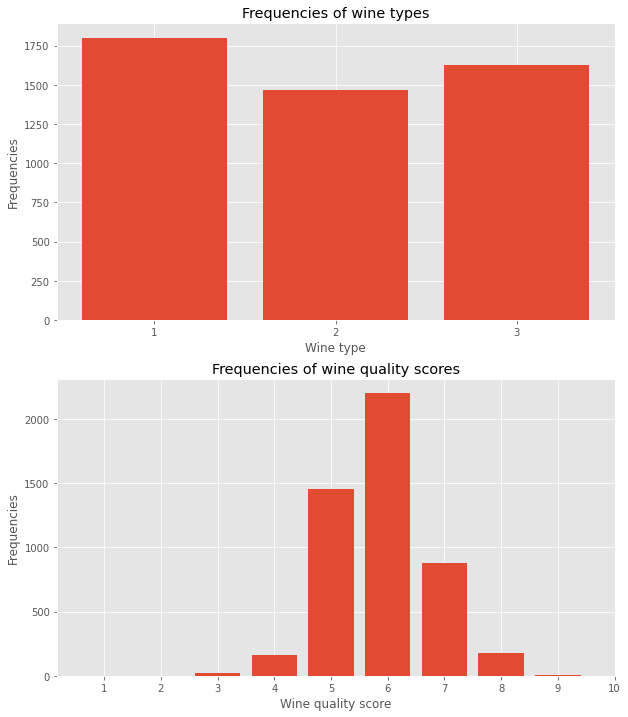

<Figure size 432x288 with 0 Axes>

there are 20 samples of wine with score 3

and there are 5 samples of wine with score 9

mean of wine quality = 5.88

std of wine quality = 0.89


In [ ]:
num_type = []
for i in range(0, max(y_wine_type), 1):
    num_type.append(sum(y_wine_type==i+1))
print(num_type)

num_quality = []
for i in range(0, max(y_wine_quality), 1):
    num_quality.append(sum(y_wine_quality==i+1))
print(num_quality)

fig, axs = plt.subplots(2,1, figsize=(10,12))
fig = plt.figure()
axs[0].bar(range(1, max(y_wine_type)+1, 1), num_type)
axs[0].set_title('Frequencies of wine types')
axs[0].set_ylabel('Frequencies')
axs[0].set_xlabel('Wine type')
axs[0].set_xticks(np.arange(1,4,1))

axs[1].bar(range(1, max(y_wine_quality)+1, 1), num_quality)
axs[1].set_title('Frequencies of wine quality scores')
axs[1].set_ylabel('Frequencies')
axs[1].set_xlabel('Wine quality score')
axs[1].set_xticks(np.arange(1,11,1))

plt.show()

print("there are", sum(y_wine_quality==3), "samples of wine with score 3\n")
print("and there are", sum(y_wine_quality==9), "samples of wine with score 9\n")

print(f"mean of wine quality = {np.mean(y_wine_quality):.2f}")
print(f"\nstd of wine quality = {np.std(y_wine_quality):.2f}")

## Correlation plots
code from [here](https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
)

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [ ]:
wine_corr = df_wine.corr().abs()
print("Top Absolute Correlations")
print(get_top_abs_correlations(df_wine, 20))

Top Absolute Correlations
residual.sugar        density                 0.838966
density               alcohol                 0.780138
                      type                    0.704534
residual.sugar        type                    0.647108
free.sulfur.dioxide   total.sulfur.dioxide    0.615501
alcohol               type                    0.576035
total.sulfur.dioxide  density                 0.529881
                      type                    0.502521
residual.sugar        alcohol                 0.450631
total.sulfur.dioxide  alcohol                 0.448892
alcohol               quality                 0.435575
fixed.acidity         pH                      0.425858
pH                    type                    0.409653
residual.sugar        total.sulfur.dioxide    0.401439
free.sulfur.dioxide   type                    0.371048
chlorides             alcohol                 0.360189
fixed.acidity         type                    0.353686
density               quality          

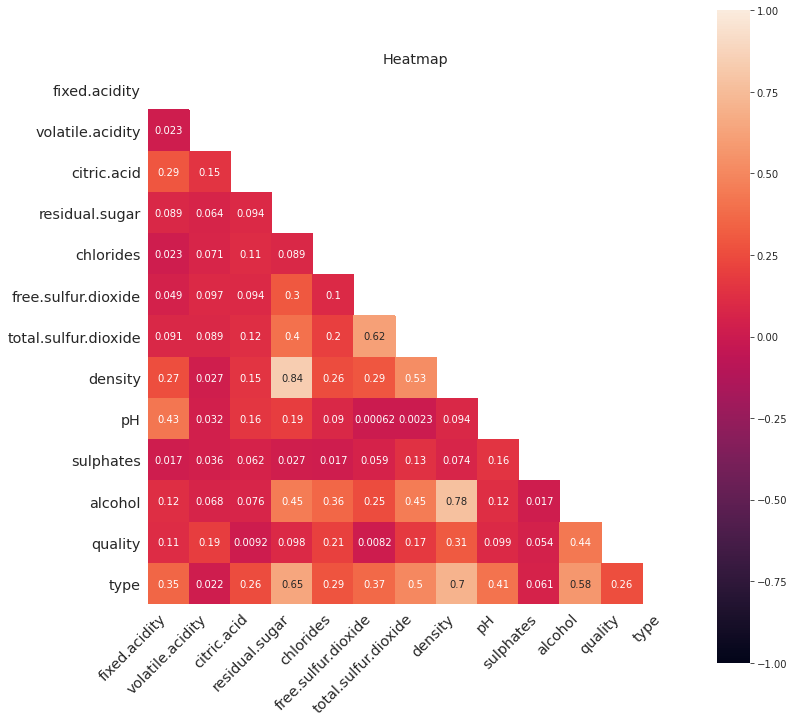

In [ ]:
mask = np.zeros_like(wine_corr)
mask[np.triu_indices_from(mask)] = True # comment this out to get full correlation matrix
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(12, 12))
    ax.set_title("Heatmap")
    ax = sns.heatmap(wine_corr, mask=mask, annot=True, vmax=1, vmin=-1, square=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right',
                      fontweight='light', fontsize='x-large')
    ax.set_yticklabels(ax.get_xticklabels(), horizontalalignment='right',
                      fontweight='light', fontsize='x-large')
plt.show()

## Feature distributions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

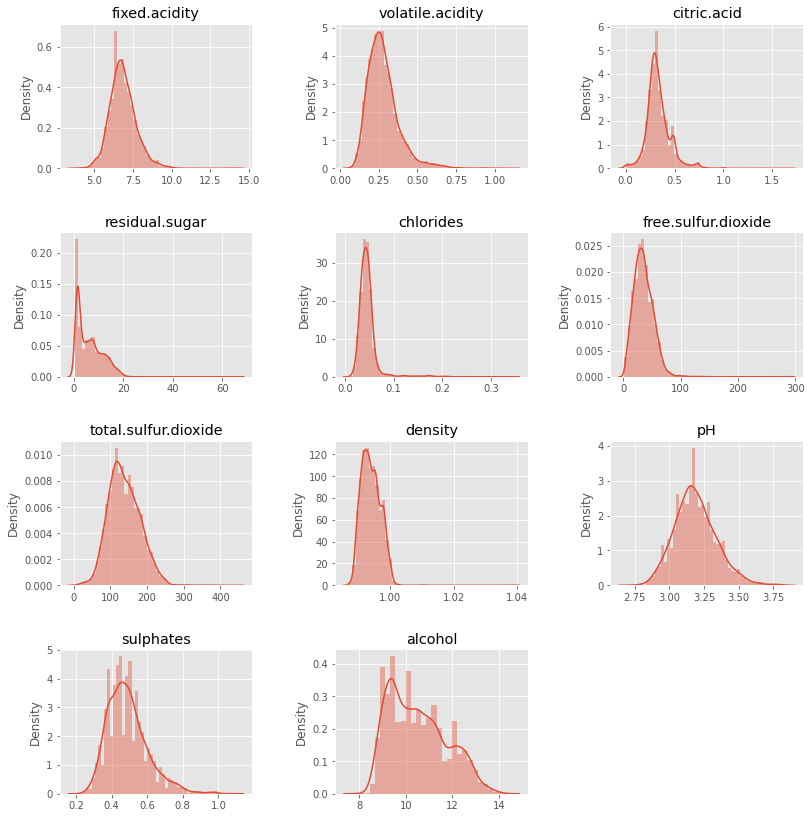

In [ ]:
fig, axs = plt.subplots(4,3,figsize=(12,12))

for ax, var in zip(axs.reshape(-1), df_wine.iloc[:, :-2]): 
    sns.distplot(df_wine[var], ax=ax)
    ax.set_title(var)
    ax.set_xlabel('')

fig.tight_layout(pad=3.0)
axs[-1, -1].axis('off')    
plt.show()

## Feature distribution by wine type

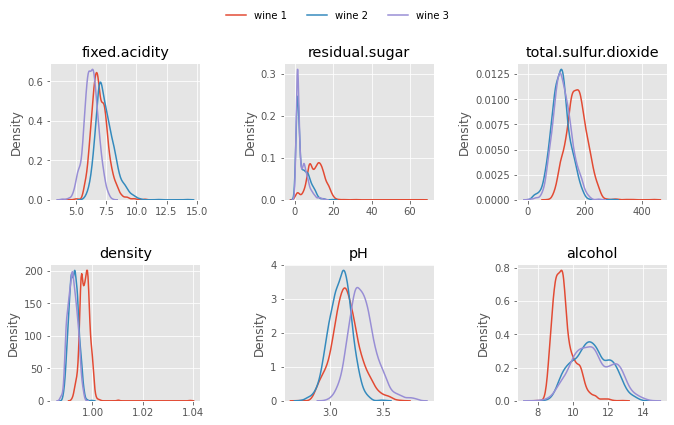

In [ ]:
label_type = [1,2,3]

# fig, axs = plt.subplots(4,3,figsize=(12,12))
fig, axs = plt.subplots(2,3,figsize=(10,6))
# picking out the ones where distributions differ
for ax, var in zip(axs.reshape(-1), df_wine.iloc[:, [0,3,6,7,8,10]]): # df_wine.iloc[:, :-2]): 
    for wine in label_type:
        mask = df_wine["type"]==wine
        plot_data = df_wine.loc[mask,]
        sns.kdeplot(plot_data[var], ax=ax, label="wine "+ str(wine))
        ax.set_title(var)
        ax.set_xlabel('')
        #ax.set_ylabel('Density')

axs[0,0].set_ylabel('Density')
axs[1,0].set_ylabel('Density')
#axs[2,0].set_ylabel('Density')
#axs[3,0].set_ylabel('Density')
fig.tight_layout(pad=3.0)
#axs[-1, -1].axis('off')   

# axs[0,0].legend(ncol=6, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', frameon=False)
axs[0,0].legend(bbox_to_anchor=(0.5, 1), loc='center', bbox_transform=fig.transFigure,
               frameon=False, ncol=3)

[ax.legend().remove() for ax in axs.reshape(-1)[1:]];

plt.show()


## PCA for dimensionality reduction

The actual PCA plots are further down in this notebook in [this section](#cell-id). Below, is a scatter function (based on code from DME labs) to visualise PCA embeddings. 

In [ ]:
def scatter_2d_label_LOF(X_2d, y, X_scores, uncertainty, descr,
                         ax=None, s=2, alpha=0.5, lw=2):
    """Visualise a 2D embedding with corresponding labels.
    
    X_2d : ndarray, shape (n_samples,2)
        Low-dimensional feature representation.
    
    y : ndarray, shape (n_samples,)
        Labels corresponding to the entries in X_2d.
        
    X_scores : scores from LOF fit_predict
        
    ax : matplotlib axes.Axes 
         axes to plot on
         
    s : float
        Marker size for scatter plot.
    
    alpha : float
        Transparency for scatter plot.
        
    lw : float
        Linewidth for scatter plot.
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(palette='bright', n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                   color=color, label=target, s=s, alpha=alpha, lw=lw)
        
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                     edgecolors=color, label='Outlier scores', 
                     s=1000 * radius[y == target], 
                     alpha=alpha, lw=lw, facecolors='none')
        
    ax.scatter(X_2d[uncertainty, 0], X_2d[uncertainty, 1], color="black", s=10,
               label=descr)
    
    ax.set_xlabel("Principle Component 1")
    ax.set_ylabel("Principle Component 2")
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax


In [ ]:
def scatter_2d_label_LOF_with_highest(X_2d, y, X_scores, uncertainty, 
                                      highest_uncertainty, descr, 
                                      descr_2, ax=None, s=2, alpha=0.5, lw=2):
    """
    2nd version of scatter plot to highlight sample with highest uncertainty
    """
    
    targets = np.unique(y)  # extract unique labels
    colors = sns.color_palette(palette='bright', n_colors=targets.size)
    
    if ax is None:
        fig, ax = plt.subplots()
        
    # scatter plot    
    for color, target in zip(colors, targets):
        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                   color=color, label=target, s=s, alpha=alpha, lw=lw)
        
        radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())

        ax.scatter(X_2d[y == target, 0], X_2d[y == target, 1], 
                     edgecolors=color, label='Outlier scores', 
                     s=1000 * radius[y == target], 
                     alpha=alpha, lw=lw, facecolors='none')
        
    ax.scatter(X_2d[uncertainty, 0], X_2d[uncertainty, 1], color="black", s=10,
               label=descr)
    ax.scatter(X_2d[highest_uncertainty, 0], X_2d[highest_uncertainty, 1], 
               color="red", s=200, label=descr_2)
    ax.set_xlabel("Principle Component 1")
    ax.set_ylabel("Principle Component 2")
    # add legend
    ax.legend(loc='center left', bbox_to_anchor=[1.01, 0.5], scatterpoints=3, frameon=False); # Add a legend outside the plot at specified point
    
    return ax


before continuing with the next part, we call the data with standardised features. This is particularly important for the PCA results. Furthermore, the labels are transformed to one-hot encodings

In [4]:
(df_wine, y_wine_type, y_wine_quality, X_wine,
    X_wine_test, y_wine_test_type, y_wine_test_quality,
    X_wine_train, y_wine_train_type, y_wine_train_quality,
    X_wine_val, y_wine_val_type, y_wine_val_quality) = get_sc_wine_data()

In [5]:
y_wine_type_original = y_wine_type
y_wine_type = tf.keras.utils.to_categorical(y_wine_type-1, num_classes=3)

y_wine_test_type_original = y_wine_test_type
y_wine_test_type = tf.keras.utils.to_categorical(y_wine_test_type-1, num_classes=3)

y_wine_train_type_original = y_wine_train_type
y_wine_train_type = tf.keras.utils.to_categorical(y_wine_train_type-1, num_classes=3)

y_wine_val_type_original = y_wine_val_type
y_wine_val_type = tf.keras.utils.to_categorical(y_wine_val_type-1, num_classes=3)

# Save function
for trained models

In [ ]:
def save_model(model, batch_size, n_epochs, descr, n_hidden, dropout=None):
    fpf = '/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models'
    fp0 = "/model_" + descr
    fp1 = "_batchsize" + str(batch_size)
    fp2 = "_nepoch" + str(n_epochs)
    if dropout == None:
        fp3 = ""
    else:
        fp3 = '_dropout' + str(dropout*10)

    fp4 = "_nhidden"
    for i in n_hidden:
      fp4 = fp4 + "_" + str(i)
    fp5 = ".h5"

    fp_full = fpf + fp0 + fp1 + fp2 + fp3 + fp4 + fp5

    model.save(fp_full)

# Loss function

In [6]:
def softmax(pred):
  return K.exp(pred - K.log(K.sum(K.exp(pred))))  # numerically stable softmax
  
def softmax_np(pred):
  return np.exp(pred - np.log(np.sum(np.exp(pred), axis=1)).reshape(pred.shape[0],1))  

def gaussian_softmax(ypred, dist, num_classes):
  def map_fn(i):
    std_samples = K.transpose(dist.sample(num_classes))
    distorted_loss = softmax(ypred + std_samples)
    return distorted_loss
  return map_fn

# aleatoric loss function
def bayesian_categorical_crossentropy(T, num_classes):
  def bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
    std = K.exp(0.5*ypred_var[:, num_classes:])[0] # add this 
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')
    
    variance_loss = K.categorical_crossentropy(ytrue, K.mean(monte_carlo_results, axis=0))
    
    return variance_loss 
  
  return bayesian_categorical_crossentropy_internal

def simple_bayesian_categorical_crossentropy_internal(ytrue, ypred_var):
  #A slight modification to the original fuction for the simple example
    std = K.exp(0.5*ypred_var[:, num_classes:])[0] # here too
    ypred = ypred_var[:, 0:num_classes]
    iterable = K.variable(np.ones(T))
    dist = distributions.Normal(loc=K.zeros_like(std), scale=std)
    monte_carlo_results = K.map_fn(gaussian_softmax(ypred, dist, num_classes),
                                   iterable, name='monte_carlo_results')
    
    predictions = K.categorical_crossentropy(ytrue, y_pred)
    
    return predictions 



# Loss and accuracy plot function

In [ ]:
def loss_accuracy_plot(fit_history):
  # Plot training & validation accuracy values
  plt.plot(fit_history.history['accuracy'])
  plt.plot(fit_history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

# Model specification

In [7]:
def get_model(act="relu", n_hidden=[64, 64], dropout_prob=0.0, 
              loss=keras.losses.categorical_crossentropy, include_logvar=False,
              optimizer=keras.optimizers.Adadelta()):
    N = 11 # only dealing with same inputs
    reg = (1 - dropout_prob) / (2. * N) if dropout_prob > 0 else 0

    inputs = Input(input_shape)
    inter = Dense(n_hidden[0], activation=act,
                  kernel_regularizer=l2(reg))(inputs)

    for i in range(len(n_hidden) - 1):
        inter = Dropout(dropout_prob)(inter, training=True)
        inter = Dense(n_hidden[i+1], activation=act,
                      kernel_regularizer=l2(reg))(inter)

    inter = Dropout(dropout_prob)(inter, training=True)
    inter = Flatten()(inter)

    if include_logvar: # for inclusion of aleatoric variance
        outputs = Dense(num_classes+1, activation=None, 
                        kernel_regularizer=l2(reg))(inter) 
    else:
        outputs = Dense(num_classes, activation='softmax', 
                        kernel_regularizer=l2(reg))(inter) 
    
    model = Model(inputs=inputs, outputs=outputs)

    metrics = ['accuracy']
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics,
                  run_eagerly=True)
    return model

# Baseline Model

Different values for the parameters

* batch_size

* learning_rate

* n_hidden

were tried (see Appendix). The specifications below yielded one of the best performance on the validation set

In [16]:
# fixed params
num_classes = 3
input_shape = (11)

# hyperparameters
batch_size = 128
epochs = 20
dropout_p = 0.0
n_hidden = [64, 64] 
learning_rate = 0.001

In [ ]:
model_orig = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_orig.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195   

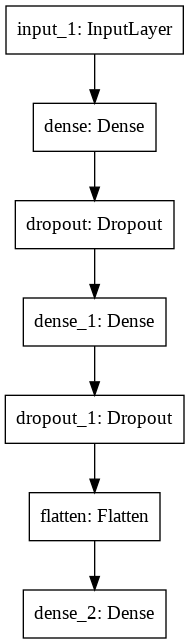

In [ ]:
plot_model(model_orig)

## Model fitting

We have already decided which hyperparameters to use on the validation data (see appendix). From now on, we will be using the test set for any further evaluations as well as computations of uncertainties.

In [ ]:
history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
23/23 [==============================] - 1s 21ms/step - loss: 0.8571 - accuracy: 0.6814 - val_loss: 0.5954 - val_accuracy: 0.8714
Epoch 2/20
23/23 [==============================] - 1s 24ms/step - loss: 0.4599 - accuracy: 0.9061 - val_loss: 0.3101 - val_accuracy: 0.9459
Epoch 3/20
23/23 [==============================] - 1s 22ms/step - loss: 0.2543 - accuracy: 0.9530 - val_loss: 0.1821 - val_accuracy: 0.9633
Epoch 4/20
23/23 [==============================] - 1s 23ms/step - loss: 0.1632 - accuracy: 0.9694 - val_loss: 0.1296 - val_accuracy: 0.9684
Epoch 5/20
23/23 [==============================] - 0s 19ms/step - loss: 0.1207 - accuracy: 0.9765 - val_loss: 0.1033 - val_accuracy: 0.9745
Epoch 6/20
23/23 [==============================] - 0s 19ms/step - loss: 0.0965 - accuracy: 0.9786 - val_loss: 0.0879 - val_accuracy: 0.9776
Epoch 7/20
23/23 [==============================] - 0s 18ms/step - loss: 0.0805 - accuracy: 0.9837 - val_loss: 0.0768 - val_accuracy: 0.9786
Epoch 8/20
23

In [ ]:
save_model(model=model_orig, batch_size=batch_size, n_hidden=n_hidden,
           n_epochs=epochs, descr="orig_wine", dropout=None)

In [ ]:
model_orig = orig_mnist_model_cnn = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_orig_wine_batchsize128_nepoch20_nhidden_64_64.h5")

In [ ]:
loss_orig_eval, accuracy_orig_eval = model_orig.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_orig_eval}, Eval accuracy = {accuracy_orig_eval}")

Eval loss = 0.04000842943787575, Eval accuracy = 0.9918367266654968


# EPISTEMIC

In [ ]:
# fixed params
num_classes = 3
input_shape = (11)

# try different options for these
batch_size = 128
epochs = 20
dropout_p = 0.2
n_hidden = [64, 64] 
learning_rate = 0.001

## Model fitting

In [ ]:
"""mc_model = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
mc_model.summary()"""

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195 

In [ ]:
"""history_mc_model = mc_model.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)"""

Epoch 1/20
23/23 [==============================] - 1s 25ms/step - loss: 3.8563 - accuracy: 0.5861 - val_loss: 3.3574 - val_accuracy: 0.7980
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 2.9981 - accuracy: 0.8291 - val_loss: 2.6171 - val_accuracy: 0.8765
Epoch 3/20
23/23 [==============================] - 1s 24ms/step - loss: 2.3563 - accuracy: 0.8836 - val_loss: 2.0686 - val_accuracy: 0.9122
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 1.8824 - accuracy: 0.9013 - val_loss: 1.6569 - val_accuracy: 0.9357
Epoch 5/20
23/23 [==============================] - 0s 20ms/step - loss: 1.5346 - accuracy: 0.9224 - val_loss: 1.3665 - val_accuracy: 0.9204
Epoch 6/20
23/23 [==============================] - 1s 23ms/step - loss: 1.2723 - accuracy: 0.9340 - val_loss: 1.1377 - val_accuracy: 0.9469
Epoch 7/20
23/23 [==============================] - 1s 23ms/step - loss: 1.0880 - accuracy: 0.9394 - val_loss: 0.9857 - val_accuracy: 0.9469
Epoch 8/20
23

In [ ]:
"""save_model(model=mc_model, batch_size=batch_size, n_hidden=n_hidden,
           n_epochs=epochs, descr="mc_model_wine", dropout=dropout_p)"""

In [7]:
mc_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_mc_model_wine_batchsize128_nepoch20_dropout2.0_nhidden_64_64.h5")

In [ ]:
loss_mc_model_eval, mc_model_accuracy_eval = mc_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_mc_model_eval}, Eval accuracy = {mc_model_accuracy_eval}")

Eval loss = 0.570581316947937, Eval accuracy = 0.954081654548645


## accuracy plots

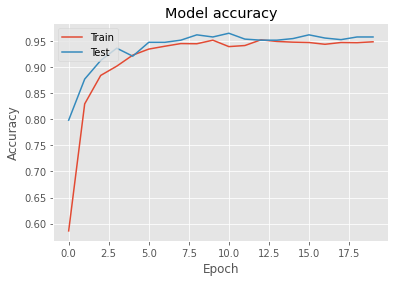

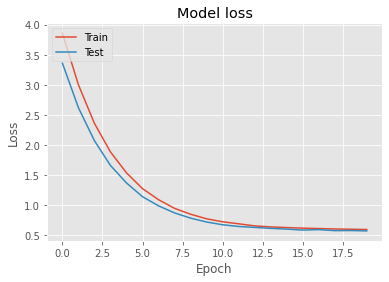

In [ ]:
"""loss_accuracy_plot(history_mc_model)"""

## Functions for epistemic uncertainties

In [22]:
# making 100 predictions for each sample of val set for each class
import tqdm
def make_predictions(model, n_pred=100, batch_size=100, val_data=X_wine_test):
  predictions = []
  for i in tqdm.tqdm(range(n_pred)):
      y_p = model.predict(val_data, batch_size=batch_size)
      predictions.append(y_p)
  return predictions

In [23]:
# calculate mean predictions, std, and epistemic uncertainty
def cal_epistemic(predictions):
  p = np.array(predictions)
  y_mean = p.mean(axis=0) # prediction mean of 100 predictions
  w = 1/np.sum(y_mean, axis=1).reshape(y_mean.shape[0],1)
  y_mean = (y_mean*w)
  y_std = p.std(axis=0)*w

  epi_1 = y_std.max(axis=1)
  epi_2 = y_std.mean(axis=1)
  epi_3 = -(p.mean(axis=0) * np.log(p.mean(axis=0))).sum(axis=1)
  return y_mean, y_std, [epi_1, epi_2, epi_3]

In [24]:
# calculate mean ensemble prediction and accuracy
def ensemble_pred(predictions, val_data=y_wine_test_type):
  ensemble_pred = np.array(predictions).mean(axis=0).argmax(axis=1) # max mean pred
  ensemble_acc = accuracy_score(val_data.argmax(axis=1), ensemble_pred)
  print("MC-ensemble accuracy: {:.1%}".format(ensemble_acc))
  return ensemble_pred, ensemble_acc

In [25]:
def show_epistemic(epi, prediction, highest=True, n_epi=20,
                   x_data=X_wine_test, y_data=y_wine_test_type_original):
  if highest == True:
    epi_idx = epi.argsort()[::-1]
  if highest == False:
    epi_idx = epi.argsort()

  plt.hist(y_data.iloc[epi_idx[:n_epi]])
  plt.show()
  for idx in epi_idx[:n_epi]:
    print("True label of the test sample {}: {}".format(idx, y_data.iloc[idx], axis=-1))
    print(f"Predicted label of test sample {idx}: {prediction[idx]+1}")
    print(f"Epistemic uncertainty: {epi[idx]:.4}")
    plt.show()

## Calculating epistemic uncertainties


In [ ]:
mc_predictions = make_predictions(mc_model)
mc_ensemble_pred, mc_ensemble_acc = ensemble_pred(mc_predictions)
mc_y_mean, mc_y_std, mc_epistemic = cal_epistemic(mc_predictions)

100%|██████████| 100/100 [00:08<00:00, 11.88it/s]

MC-ensemble accuracy: 98.0%


In [ ]:
np.median(mc_epistemic[0])

0.06931226

In [ ]:
"""from numpy import savetxt
fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_saved_uncertainties"
savetxt(fp + '/mc_epistemic_wine.csv', mc_epistemic, delimiter=',')"""

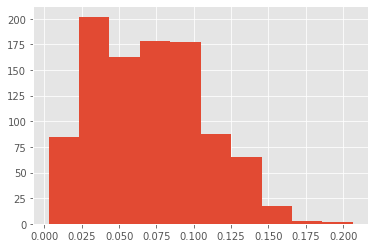

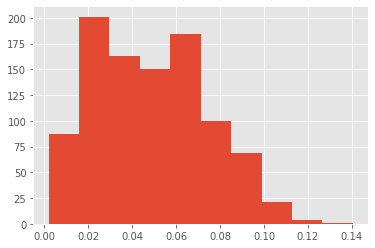

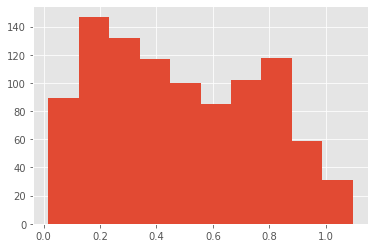

In [ ]:
for i in [0,1,2]:
  plt.hist(mc_epistemic[i])
  plt.show()

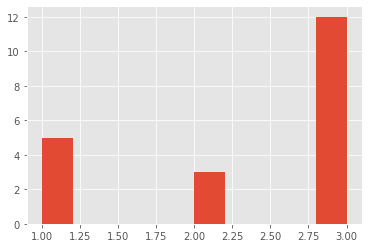

True label of the test sample 366: 1
Predicted label of test sample 366: 1
Epistemic uncertainty: 0.2066
True label of the test sample 679: 1
Predicted label of test sample 679: 1
Epistemic uncertainty: 0.1864
True label of the test sample 239: 1
Predicted label of test sample 239: 1
Epistemic uncertainty: 0.1787
True label of the test sample 933: 3
Predicted label of test sample 933: 3
Epistemic uncertainty: 0.1767
True label of the test sample 148: 3
Predicted label of test sample 148: 3
Epistemic uncertainty: 0.1696
True label of the test sample 504: 3
Predicted label of test sample 504: 3
Epistemic uncertainty: 0.1654
True label of the test sample 677: 3
Predicted label of test sample 677: 3
Epistemic uncertainty: 0.1603
True label of the test sample 43: 1
Predicted label of test sample 43: 1
Epistemic uncertainty: 0.1583
True label of the test sample 749: 3
Predicted label of test sample 749: 3
Epistemic uncertainty: 0.156
True label of the test sample 388: 3
Predicted label of te

In [ ]:
show_epistemic(mc_epistemic[0], mc_ensemble_pred)

<a name="cell-id"></a>
## Plotting Wine PCA with epistemic uncertainties and LOF anomalies


### PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)  # Initialise a PCA instance
X_pca_wine = pca.fit_transform(X_wine_test)

In [ ]:
X_pca_wine

array([[-0.65974147, -1.7082156 ],
       [ 1.830381  ,  0.04103752],
       [ 6.93717581,  0.74225613],
       ...,
       [-1.98391262,  1.56761577],
       [ 1.74566321,  0.53319437],
       [-0.69925812, -1.77969585]])

In [ ]:
epi_idx = mc_epistemic[2].argsort()[::-1]
# want to plot n samples with highest epistemic uncertainty
n = 200
highest_epi = epi_idx[:n]

### LOF

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
clf_wine = LocalOutlierFactor(n_neighbors=10)
result_wine = clf_wine.fit_predict(X_wine_test)

# outliers predicted with LOF
outlier_index_wine = np.where(result_wine == -1)
X_scores_wine = clf_wine.negative_outlier_factor_
print(len(outlier_index_wine[0]))
print(outlier_index_wine)

26
(array([ 82,  93, 109, 154, 205, 216, 239, 255, 282, 355, 398, 426, 459,
       479, 501, 523, 540, 643, 646, 679, 763, 853, 872, 885, 897, 919]),)


In [ ]:
# difference to before: LOF embeddings on PCA vector rather than original vector
clf_wine = LocalOutlierFactor(n_neighbors=10)
result_wine_PCA = clf_wine.fit_predict(X_pca_wine)
outlier_index_wine_PCA = np.where(result_wine_PCA == -1)
X_scores_wine_PCA = clf_wine.negative_outlier_factor_
print(len(outlier_index_wine_PCA[0]))
outlier_index_wine_PCA

21


(array([  2,  94, 148, 195, 205, 214, 215, 230, 239, 342, 366, 423, 425,
        450, 475, 674, 679, 802, 885, 950, 955]),)

### Plot PCA, LOF

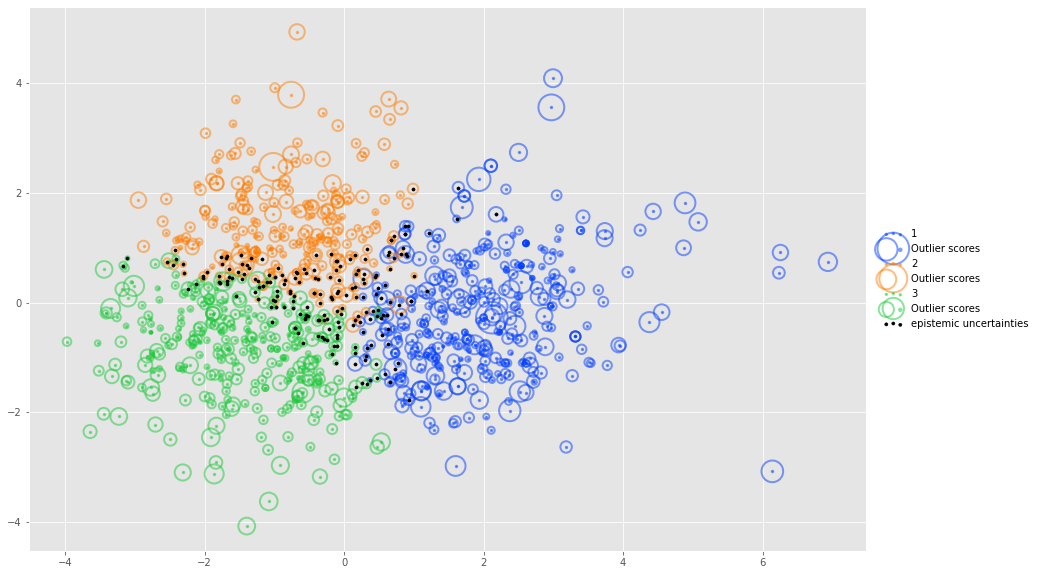

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_epi, descr="epistemic uncertainties",
                     ax=ax, s=2, alpha=0.5, lw=2)

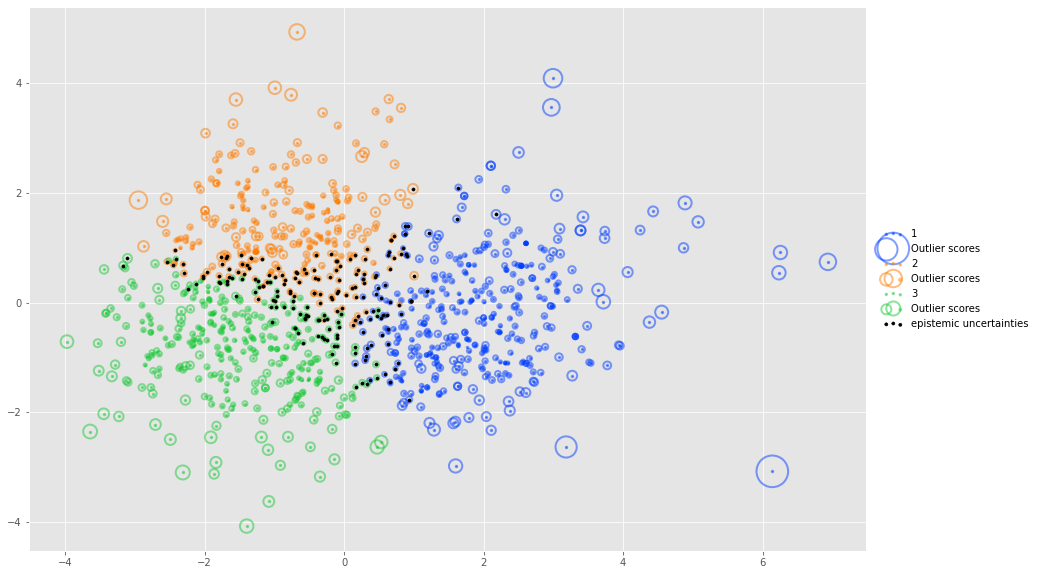

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine_PCA, highest_epi, descr="epistemic uncertainties",
                     ax=ax, s=2, alpha=0.5, lw=2)

## Check if epistemic uncertainty decreases with increasing sample size

As epistemic uncertainty can be explained away with more data, expecting a decrease of epistemic uncertainty for increasing training sizes

In [12]:
# sample_sizes = [0.5, 0.6, 0.7, 0.8, 0.9]
# sample_sizes = [0.5, 0.75]
sample_sizes = [1/8, 1/4, 1/2]

def check_epistemic(X_train, y_train, X_test, y_test, sample_sizes, model,
                    random_state=10):
  # for loop to calculate epistemic uncertainties for different sample sizes
  epi_list = []
  epi_mean_list = []

  for sample_size in sample_sizes:
      # create differnt training sizes
      (X_train_helper, _, 
      y_train_helper, _) = train_test_split(X_train, 
                                            y_train,
                                            test_size=1-sample_size,
                                            random_state=random_state)

      # fit the model
      mc_model_helper = get_model(act="relu", dropout_prob=0.2, n_hidden=[64,64],
                            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
      history_mc_model_helper = mc_model_helper.fit(X_train_helper, y_train_helper, 
                          validation_data=(X_test, y_test), 
                          batch_size=128, epochs=20, verbose=0)
      
      # calculate epistemic uncertainties
      mc_predictions_helper = make_predictions(mc_model_helper)
      mc_y_mean_helper, mc_y_std_helper, mc_epistemic_helper = cal_epistemic(mc_predictions_helper)
      epi_list.append(mc_epistemic_helper)
      epi_mean_list.append(np.mean(mc_epistemic_helper, axis=1))

  # repeat for the original (full) model as well
  mc_predictions_helper = make_predictions(model)
  mc_y_mean_helper, mc_y_std_helper, mc_epistemic_helper = cal_epistemic(mc_predictions_helper)
  epi_list.append(mc_epistemic_helper)
  epi_mean_list.append(np.mean(mc_epistemic_helper, axis=1))

  return epi_list, epi_mean_list

In [13]:
num_classes = 3
input_shape = (11)
batch_size = 128
epochs = 20
dropout_p = 0.2
n_hidden = [64, 64] 
learning_rate = 0.001

  2%|▏         | 2/100 [00:00<00:09, 10.18it/s]

hey


  1%|          | 1/100 [00:00<00:11,  8.58it/s]

hey


  1%|          | 1/100 [00:00<00:11,  8.51it/s]

hey


100%|██████████| 100/100 [00:07<00:00, 14.28it/s]


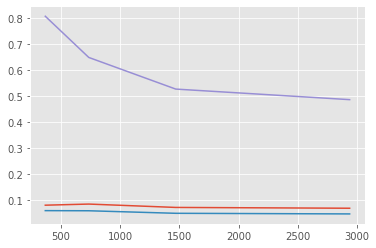

In [26]:
epi_list, epi_mean_list = check_epistemic(X_train=X_wine_train, y_train=y_wine_train_type, 
                                        X_test=X_wine_test, y_test=y_wine_test_type, 
                                        sample_sizes=sample_sizes, 
                                        model=mc_model)

x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] 
x_samples.append(X_wine_train.shape[0])
for i in range(len(epi_mean_list[0])):
  y_epi = [epi[i] for epi in epi_mean_list]
  plt.plot(x_samples, y_epi)
plt.show()

In [28]:
from numpy import savetxt
fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/TEST_saved_uncertainties"
savetxt(fp + '/epi_decreasetrain_mean_list_wine.csv', epi_mean_list, delimiter=',')

random state is 5598


100%|██████████| 100/100 [00:08<00:00, 12.47it/s]


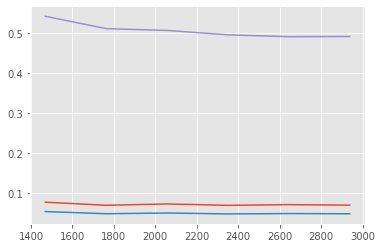

random state is 8109


100%|██████████| 100/100 [00:08<00:00, 11.52it/s]


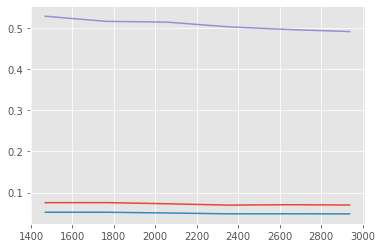

random state is 3378


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


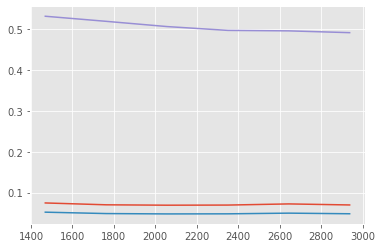

random state is 2804


100%|██████████| 100/100 [00:08<00:00, 11.86it/s]


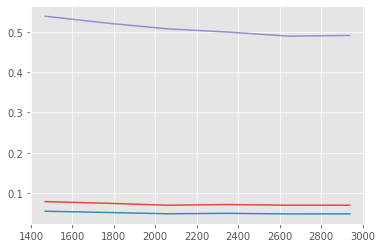

random state is 4058


100%|██████████| 100/100 [00:08<00:00, 12.14it/s]


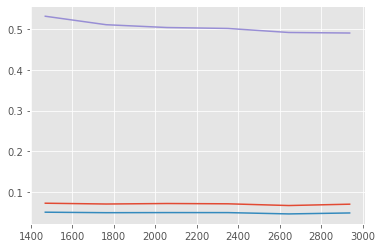

random state is 9046


100%|██████████| 100/100 [00:07<00:00, 12.55it/s]


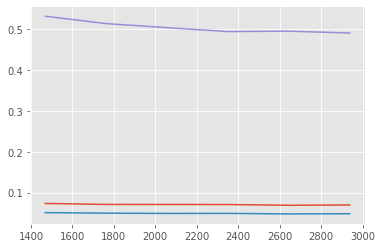

random state is 8160


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


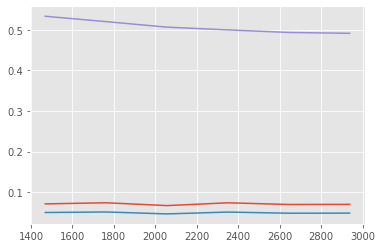

random state is 4505


100%|██████████| 100/100 [00:08<00:00, 12.21it/s]


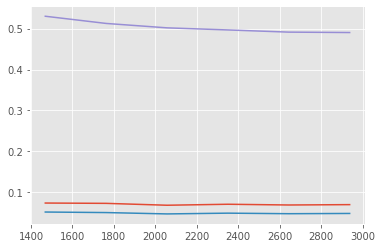

random state is 3174


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]


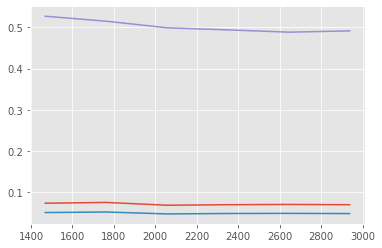

random state is 5378


100%|██████████| 100/100 [00:08<00:00, 12.39it/s]


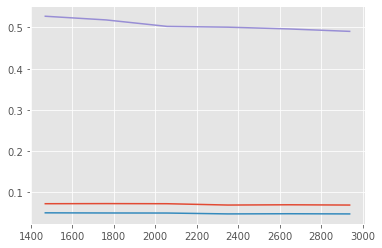

In [ ]:
"""import random
for _ in range(10): 
  random_state = random.randint(1,1e4)
  print(f"random state is {random_state}")
  epi_list, epi_mean_list = check_epistemic(X_train=X_wine_train, y_train=y_wine_train_type, 
                                         X_test=X_wine_test, y_test=y_wine_test_type, 
                                         sample_sizes=sample_sizes, 
                                         model=mc_model, random_state=random_state)

  x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] 
  x_samples.append(X_wine_train.shape[0])
  for i in range(len(epi_mean_list[0])):
    y_epi = [epi[i] for epi in epi_mean_list]
    plt.plot(x_samples, y_epi)
  plt.show()"""

Here, the epistemic uncertainty decreases with increasing training set size

# ALEATORIC

In [ ]:
num_classes=3
T = 30
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

n_hidden = [64, 64] 
batch_size = 128
epochs = 20
input_shape = (11)

## Model fitting

In [ ]:
"""alea_model = get_model(act="relu", dropout_prob=0.0, n_hidden=n_hidden,
                       include_logvar=True, loss=loss_fn,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
alea_model.summary()"""

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 260 

In [ ]:
"""history_alea_model = alea_model.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)"""

Epoch 1/20
23/23 [==============================] - 5s 182ms/step - loss: 0.9553 - accuracy: 0.2366 - val_loss: 0.7028 - val_accuracy: 0.5071
Epoch 2/20
23/23 [==============================] - 4s 182ms/step - loss: 0.5553 - accuracy: 0.6954 - val_loss: 0.3856 - val_accuracy: 0.8469
Epoch 3/20
23/23 [==============================] - 4s 181ms/step - loss: 0.3156 - accuracy: 0.8924 - val_loss: 0.2149 - val_accuracy: 0.9245
Epoch 4/20
23/23 [==============================] - 4s 154ms/step - loss: 0.1919 - accuracy: 0.9435 - val_loss: 0.1476 - val_accuracy: 0.9531
Epoch 5/20
23/23 [==============================] - 4s 157ms/step - loss: 0.1413 - accuracy: 0.9629 - val_loss: 0.1136 - val_accuracy: 0.9694
Epoch 6/20
23/23 [==============================] - 3s 153ms/step - loss: 0.1129 - accuracy: 0.9707 - val_loss: 0.0932 - val_accuracy: 0.9724
Epoch 7/20
23/23 [==============================] - 3s 154ms/step - loss: 0.0916 - accuracy: 0.9762 - val_loss: 0.0782 - val_accuracy: 0.9796
Epoch 

In [ ]:
"""save_model(model=alea_model, batch_size=batch_size, n_hidden=n_hidden,
           n_epochs=epochs, descr="alea_model_wine", dropout=None)"""

In [13]:
alea_model =  tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_alea_model_wine_batchsize128_nepoch20_nhidden_64_64.h5",
                                          custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy})

In [ ]:
loss_alea_model_eval, accuracy_alea_model_eval = alea_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_alea_model_eval}, Eval accuracy = {accuracy_alea_model_eval}")

Eval loss = 0.037917185574769974, Eval accuracy = 0.9867346882820129


## accuracy plots

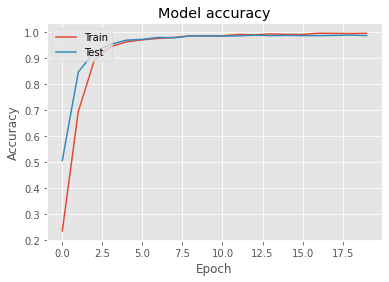

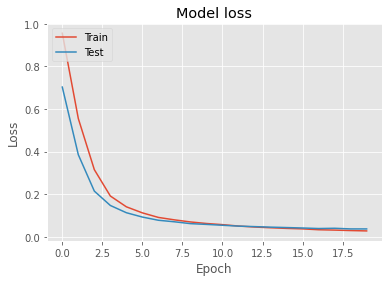

In [ ]:
loss_accuracy_plot(history_alea_model)

## Functions for aleatoric uncertainties

In [8]:
def cal_aleatoric(model, test_data=X_wine_test):
  output_alea = tf.convert_to_tensor(model.predict(test_data))
  # predicted_classes = np.argmax(output_alea[:,:3], axis=-1)
  predicted_classes = np.argmax(tf.keras.activations.softmax(output_alea[:,:3]).numpy(), 
                                axis=-1)
  sigmas = np.exp(output_alea[:,3])
  return predicted_classes, sigmas

def show_aleatoric(sigmas, prediction, highest=True, n_alea=20,
                   x_data=X_wine_test, y_data=y_wine_test_type_original):
    if highest == True:
      alea_idx = sigmas.argsort()[::-1]
    if highest == False:
      alea_idx = sigmas.argsort()
    #for idx in alea_idx[:n_alea]:
      #print(idx)
      #print(f"True label of the test sample {idx}: {y_data.iloc[idx]}")
      #print(f"Predicted label of test sample {idx}: {prediction[idx]+1}")
      #print(f"Aleatoric uncertainty: {sigmas[idx]:.4}")
      #plt.show()
    plt.hist(y_data.iloc[alea_idx[:n_alea]])
    plt.show()
    return alea_idx

## Calculating aleatoric uncertainties

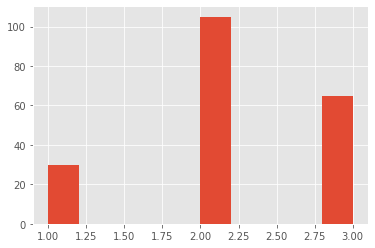

In [ ]:
pred_class_alea, sigmas_alea = cal_aleatoric(alea_model)
alea_idx = show_aleatoric(sigmas_alea, pred_class_alea, n_alea=200)

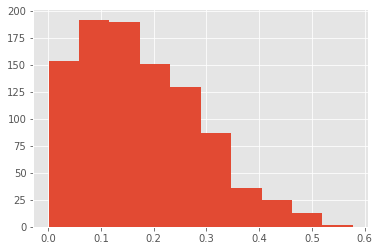

In [ ]:
plt.hist(sigmas_alea)
plt.show()

In [ ]:
fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_saved_uncertainties"
savetxt(fp + '/alea_wine.csv', sigmas_alea, delimiter=',')

## Plotting Wine PCA with aleatoric uncertainties and LOF anomalies


### Plot


In [ ]:
alea_idx = sigmas_alea.argsort()[::-1]
highest_alea = alea_idx[:200]

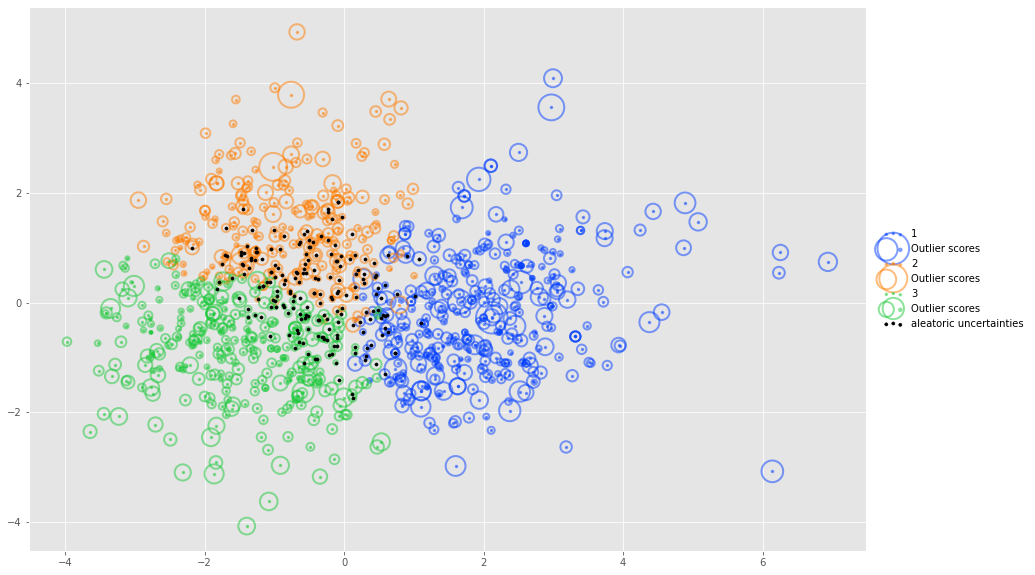

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_alea, descr="aleatoric uncertainties",
                     ax=ax, s=2, alpha=0.5, lw=2)

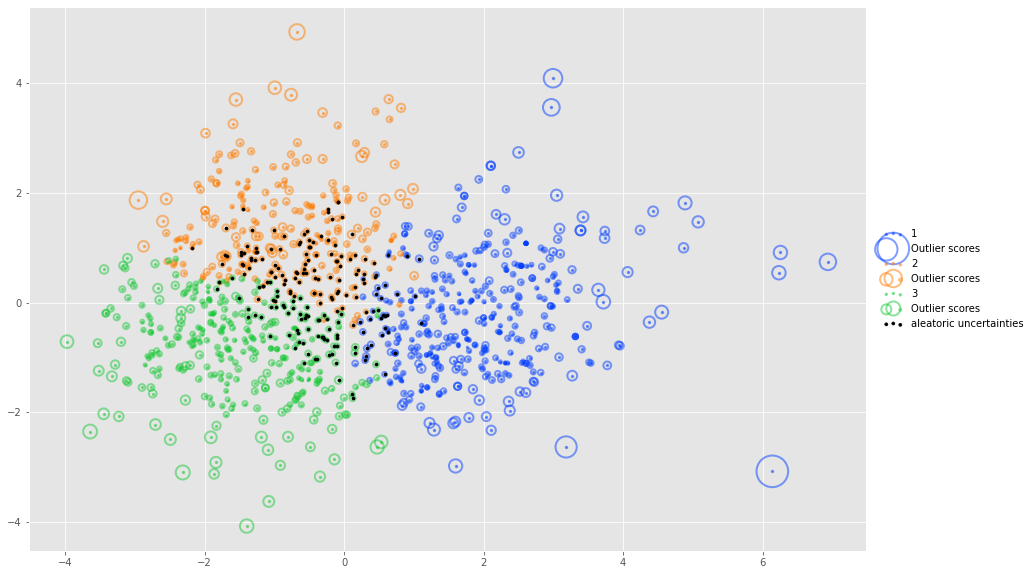

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine_PCA, highest_alea, descr="aleatoric uncertainties",
                     ax=ax, s=2, alpha=0.5, lw=2)

## Check if aleatoric uncertainty decreases when increasing the sample size

In [15]:
num_classes=3
T = 30
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

n_hidden = [64, 64] 
batch_size = 128
epochs = 20
input_shape = (11)

def check_aleatoric(X_train, y_train, X_test, y_test, sample_sizes, model, 
                    random_state=10):
  # for loop to calculate epistemic uncertainties for different sample sizes
  sigmas_list = []
  sigmas_mean_list = []

  num_classes = 3
  T = 30
  loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

  for sample_size in sample_sizes:
      # create differnt training sizes
      (X_train_helper, _, 
      y_train_helper, _) = train_test_split(X_train, 
                                            y_train,
                                            test_size=1-sample_size,
                                            random_state=random_state)
      
      alea_model_cnn_helper = get_model(act="relu", dropout_prob=0.0, n_hidden=[64, 64],
                       include_logvar=True, loss=loss_fn,
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
      
      alea_cnn_history_helper = alea_model_cnn_helper.fit(X_train_helper, y_train_helper, 
                                  validation_data=(X_test, y_test),
                                  batch_size=128, epochs=20, verbose=0)
      
      # calculate aleatoric uncertainties
      _, sigmas_alea_cnn_helper = cal_aleatoric(alea_model_cnn_helper)
      sigmas_list.append(sigmas_alea_cnn_helper)
      sigmas_mean_list.append(np.mean(sigmas_alea_cnn_helper))

  # repeat for the original model as well (i.e. with full training set)
  _, sigmas_alea_cnn_helper = cal_aleatoric(model)
  sigmas_list.append(sigmas_alea_cnn_helper)
  sigmas_mean_list.append(np.mean(sigmas_alea_cnn_helper))

  return sigmas_list, sigmas_mean_list

In [22]:
sample_sizes = [1/8, 1/4, 1/2]
sigmas_list, sigmas_mean_list = check_aleatoric(X_train=X_wine_train, y_train=y_wine_train_type, 
                                        X_test=X_wine_test, y_test=y_wine_test_type, 
                                        sample_sizes=sample_sizes, 
                                        model=alea_model, random_state=583)



In [24]:
sigmas_mean_list

[0.51731575, 0.93636525, 0.52985305, 0.17727977]

In [ ]:
[0.45164096, 0.31350178, 0.1128913, 0.17727977]

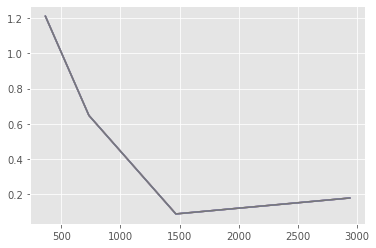

In [21]:
x_samples = [i * X_wine_train.shape[0] for i in sample_sizes] 
x_samples.append(X_wine_train.shape[0])
for i in range(len(sigmas_mean_list)):
  plt.plot(x_samples, sigmas_mean_list)
plt.show()

In [35]:
fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/TEST_saved_uncertainties"
savetxt(fp + '/sigmas_decreasetrain_mean_list_wine.csv', sigmas_mean_list, delimiter=',')

# EPISTEMIC AND ALEATORIC

## Model fitting

In [ ]:
num_classes=3
T = 30
loss_fn = bayesian_categorical_crossentropy(T=T, num_classes=num_classes)

batch_size = 128
epochs = 20
input_shape = (11)
dropout_p = 0.25
n_hidden = [64, 64]

In [ ]:
"""total_mc_model = get_model(act="relu", dropout_prob=dropout_p, n_hidden=n_hidden,
                           loss=loss_fn, include_logvar=True,
                           optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
total_mc_model.summary()"""


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 11)]              0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                768       
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 260 

In [ ]:
history_total_model = total_mc_model.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_test, y_wine_test_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/20
23/23 [==============================] - 4s 185ms/step - loss: 3.7869 - accuracy: 0.5497 - val_loss: 3.3057 - val_accuracy: 0.7571
Epoch 2/20
23/23 [==============================] - 3s 153ms/step - loss: 2.9547 - accuracy: 0.8019 - val_loss: 2.5928 - val_accuracy: 0.8714
Epoch 3/20
23/23 [==============================] - 4s 181ms/step - loss: 2.3476 - accuracy: 0.8690 - val_loss: 2.0646 - val_accuracy: 0.8959
Epoch 4/20
23/23 [==============================] - 3s 154ms/step - loss: 1.8933 - accuracy: 0.8972 - val_loss: 1.6745 - val_accuracy: 0.9265
Epoch 5/20
23/23 [==============================] - 4s 154ms/step - loss: 1.5564 - accuracy: 0.9091 - val_loss: 1.3843 - val_accuracy: 0.9245
Epoch 6/20
23/23 [==============================] - 3s 153ms/step - loss: 1.2945 - accuracy: 0.9289 - val_loss: 1.1650 - val_accuracy: 0.9418
Epoch 7/20
23/23 [==============================] - 4s 182ms/step - loss: 1.1067 - accuracy: 0.9285 - val_loss: 1.0108 - val_accuracy: 0.9418
Epoch 

In [ ]:
"""save_model(model=total_mc_model, batch_size=batch_size, n_hidden=n_hidden, 
           n_epochs=epochs, descr="total_mc_model_wine", dropout=dropout_p)"""

In [ ]:
total_mc_model =  tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_trained_models/model_total_mc_model_wine_batchsize128_nepoch20_dropout2.5_nhidden_64_64.h5",
                                          custom_objects={"bayesian_categorical_crossentropy_internal": bayesian_categorical_crossentropy})

In [ ]:
"""loss_full_model_eval, accuracy_full_model_eval = total_mc_model.evaluate(X_wine_test, y_wine_test_type, verbose=0)
print(f"Eval loss = {loss_full_model_eval}, Eval accuracy = {accuracy_full_model_eval}")"""

Eval loss = 0.5650059580802917, Eval accuracy = 0.9530612230300903


### Save all accuracies and losses so far

In [ ]:
"""all_accuracy = [accuracy_orig_eval, mc_model_accuracy_eval,
                accuracy_alea_model_eval, accuracy_full_model_eval]

all_loss = [loss_orig_eval, loss_mc_model_eval,
            loss_alea_model_eval, loss_full_model_eval]

print(all_accuracy)
print(all_loss)"""

[0.9918367266654968, 0.954081654548645, 0.9867346882820129, 0.9530612230300903]
[0.04000842943787575, 0.570581316947937, 0.037917185574769974, 0.5650059580802917]


In [ ]:
fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_accuracy_loss"
savetxt(fp + '/all_accuracy_wine.csv', all_accuracy, delimiter=',')
savetxt(fp + '/all_loss_wine.csv', all_loss, delimiter=',')

## accuracy plots

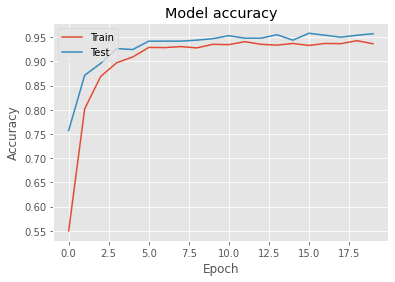

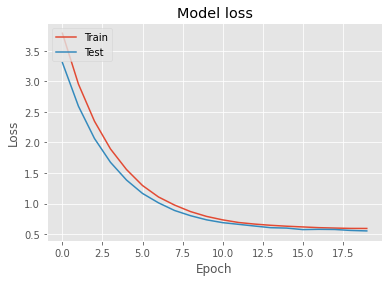

In [ ]:
"""loss_accuracy_plot(history_total_model)"""

## Calculating epistemic uncertainties

In [ ]:
import tqdm
def make_predictions_softmax(model, n_pred=100, val_data=X_wine_test):
  class_predictions = []
  for i in tqdm.tqdm(range(n_pred)):
      full_prediction = tf.convert_to_tensor(model.predict(val_data))
      y_p = tf.keras.activations.softmax(full_prediction[:,:3]).numpy()
      class_predictions.append(y_p)
  return class_predictions

In [ ]:
mc_predictions_total = make_predictions_softmax(total_mc_model)
mc_ensemble_pred_total, mc_ensemble_acc_total = ensemble_pred(mc_predictions_total)
mc_y_mean_total, mc_y_std_total, mc_epistemic_total = cal_epistemic(mc_predictions_total)

100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


MC-ensemble accuracy: 98.5%


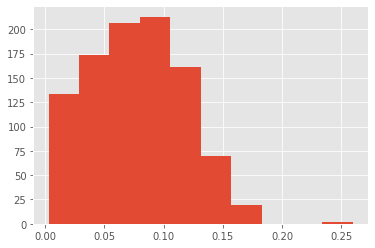

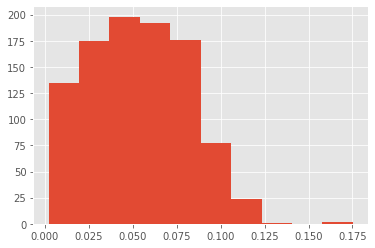

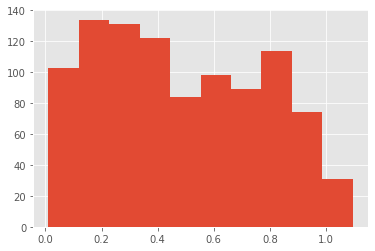

In [ ]:
for i in [0,1,2]:
  plt.hist(mc_epistemic_total[i])
  plt.show()

In [ ]:
"""fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_saved_uncertainties"
savetxt(fp + '/mc_epistemic_total_wine.csv', mc_epistemic_total, delimiter=',')"""

## Calculating aleatoric uncertainties

In [ ]:
pred_class_alea_total, sigmas_alea_total = cal_aleatoric(total_mc_model)
alea_idx_total = sigmas_alea_total.argsort()[::-1]

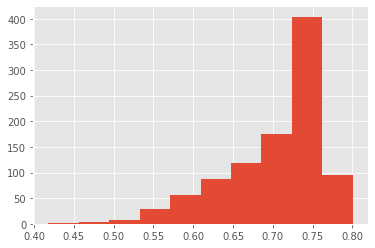

In [ ]:
plt.hist(sigmas_alea_total)
plt.show()

In [ ]:
"""fp = "/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_saved_uncertainties"
savetxt(fp + '/sigmas_alea_total_wine.csv', sigmas_alea_total, delimiter=',')"""

## plotting: PCA, epistemic, LOF

In [ ]:
epi_idx_total = mc_epistemic_total[2].argsort()[::-1]
highest_epi_total = epi_idx_total[:200]
selected_uncertainty = epi_idx_total[0]

NameError: ignored

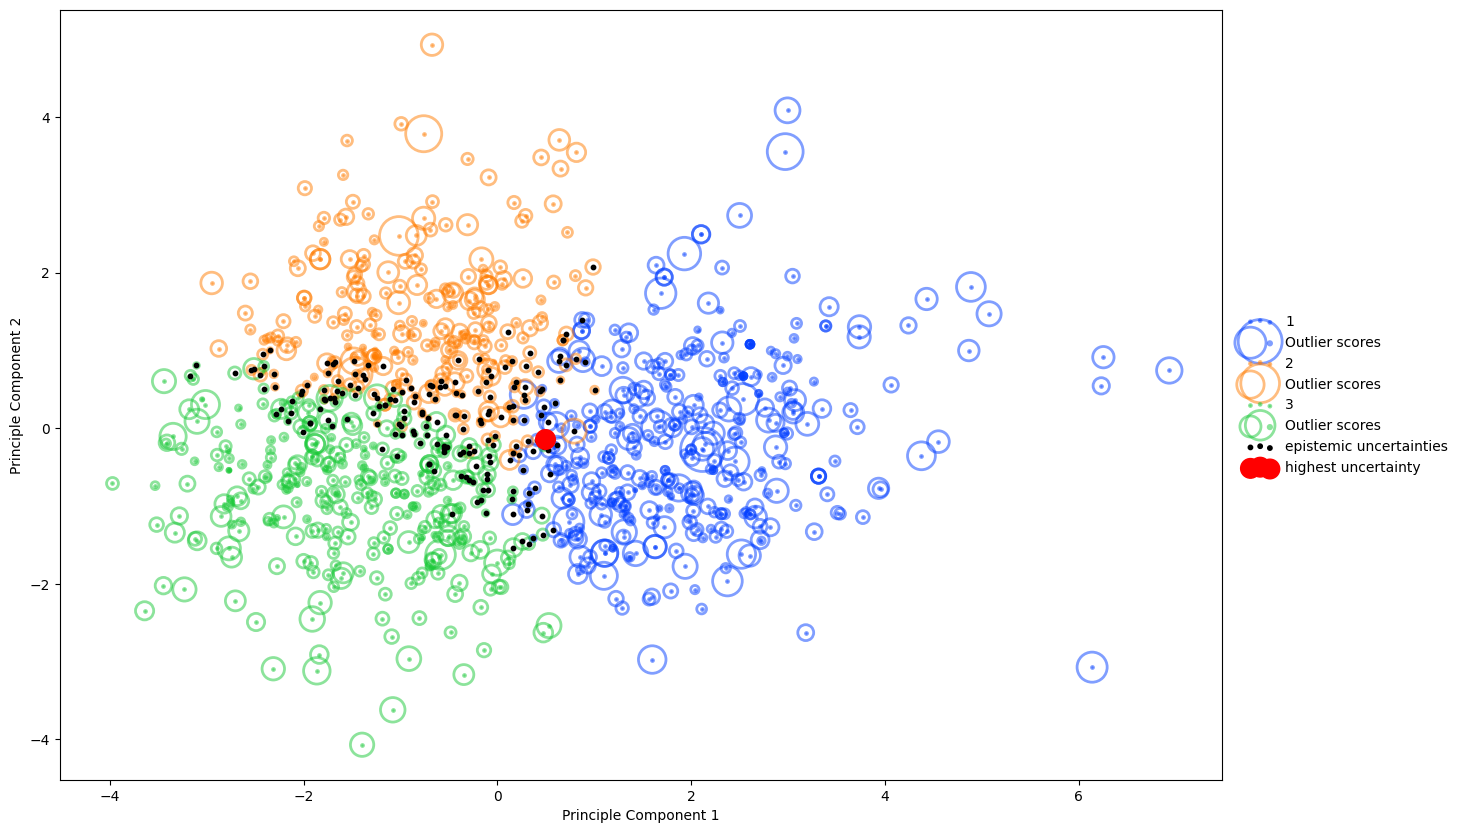

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
#plt.rcParams['axes.facecolor'] = 'white'
#plt.grid(c='white')
#plt.rcParams["axes.grid"] = True
#plt.style.context("seaborn-white")
plt.style.use('default')
scatter_2d_label_LOF_with_highest(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_epi_total,selected_uncertainty,
                     descr="epistemic uncertainties",descr_2="highest uncertainty",
                     ax=ax, s=2, alpha=0.5, lw=2)
fig.savefig('/content/drive/MyDrive/Colab Notebooks/project1_anomalydetection/FINAL_plots/PCA_epistemic.pdf', 
            transparent=True, bbox_inches='tight')

plt.show()

## plotting: PCA, aleatoric, LOF

In [ ]:
alea_idx_total = sigmas_alea_total.argsort()[::-1]
highest_alea_total = alea_idx_total[:200]

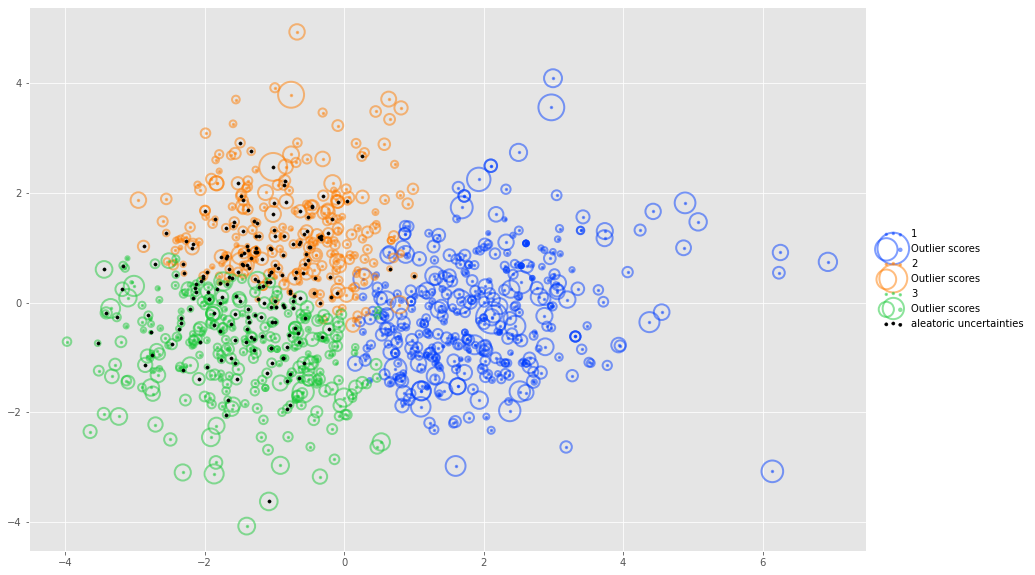

In [ ]:
fig, ax = plt.subplots(figsize=(15,10));
scatter_2d_label_LOF(X_pca_wine, y_wine_test_type_original.to_numpy(), 
                     X_scores_wine, highest_alea_total, descr="aleatoric uncertainties",
                     ax=ax, s=2, alpha=0.5, lw=2)

# Further visualisations

## effect on accuracy when deleting data points with highest uncertainties

In [ ]:
del_percentage = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
def check_acc(model, uncertainty, 
              del_percentage=del_percentage):
  accuracy_list = []
  loss_list = []
  sorted_uncertainty = uncertainty.argsort()[::-1]
  n = uncertainty.shape[0]
  for d in del_percentage:
      # drop the samples with highest uncertainty
      print(f"delete the {int(n*d)} highest uncertainties")
      drop_highest = sorted_uncertainty[int(n*d):]
      #print(drop_highest)
      loss, accuracy = model.evaluate(X_wine_test.iloc[drop_highest], 
                                      y_wine_test_type[drop_highest], 
                                      verbose=0)
      print(f"Eval loss = {loss}, Eval accuracy = {accuracy}")
      loss_list.append(loss)
      accuracy_list.append(accuracy)
  return loss_list, accuracy_list

In [ ]:
loss_list_total_mc, accuracy_list_total_mc = check_acc(model=total_mc_model, 
                                                        uncertainty=mc_epistemic_total[2])

delete the 9 highest uncertainties
Eval loss = 0.5620473027229309, Eval accuracy = 0.953656017780304
delete the 49 highest uncertainties
Eval loss = 0.5466262698173523, Eval accuracy = 0.9591836929321289
delete the 98 highest uncertainties
Eval loss = 0.5090699195861816, Eval accuracy = 0.9705215692520142
delete the 147 highest uncertainties
Eval loss = 0.4905625283718109, Eval accuracy = 0.9867947101593018
delete the 196 highest uncertainties
Eval loss = 0.47023653984069824, Eval accuracy = 0.9897959232330322
delete the 245 highest uncertainties
Eval loss = 0.44908589124679565, Eval accuracy = 0.9986394643783569
delete the 294 highest uncertainties
Eval loss = 0.4359181225299835, Eval accuracy = 0.9970845580101013
delete the 343 highest uncertainties
Eval loss = 0.41980865597724915, Eval accuracy = 1.0
delete the 392 highest uncertainties
Eval loss = 0.41508862376213074, Eval accuracy = 1.0
delete the 441 highest uncertainties
Eval loss = 0.40344277024269104, Eval accuracy = 1.0
delet

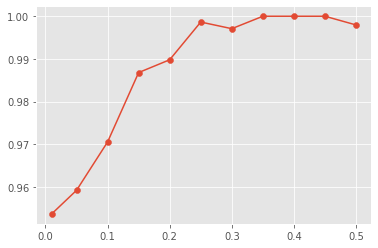

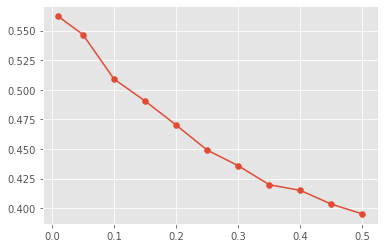

In [ ]:
plt.plot(del_percentage, accuracy_list_total_mc)
plt.scatter(del_percentage, accuracy_list_total_mc)
plt.show()

plt.plot(del_percentage, loss_list_total_mc)
plt.scatter(del_percentage, loss_list_total_mc)
plt.show()

In [ ]:
loss_list_total_mc_alea, accuracy_list_total_mc_alea = check_acc(model=total_mc_model, 
                                                        uncertainty=sigmas_alea_total)

delete the 9 highest uncertainties
Eval loss = 0.5849788188934326, Eval accuracy = 0.9546858668327332
delete the 49 highest uncertainties
Eval loss = 0.5863032341003418, Eval accuracy = 0.9462943077087402
delete the 98 highest uncertainties
Eval loss = 0.5723749995231628, Eval accuracy = 0.9523809552192688
delete the 147 highest uncertainties
Eval loss = 0.5710027813911438, Eval accuracy = 0.9615846276283264
delete the 196 highest uncertainties
Eval loss = 0.5676446557044983, Eval accuracy = 0.9477040767669678
delete the 245 highest uncertainties
Eval loss = 0.5554306507110596, Eval accuracy = 0.9537414908409119
delete the 294 highest uncertainties
Eval loss = 0.5363954305648804, Eval accuracy = 0.9504373073577881
delete the 343 highest uncertainties
Eval loss = 0.5317550897598267, Eval accuracy = 0.9576138257980347
delete the 392 highest uncertainties
Eval loss = 0.5264424681663513, Eval accuracy = 0.9506802558898926
delete the 441 highest uncertainties
Eval loss = 0.5118597745895386,

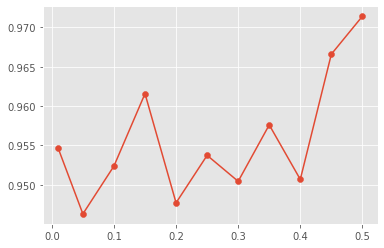

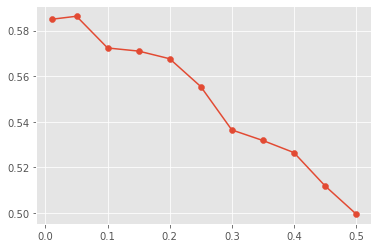

In [ ]:
plt.plot(del_percentage, accuracy_list_total_mc_alea)
plt.scatter(del_percentage, accuracy_list_total_mc_alea)
plt.show()

plt.plot(del_percentage, loss_list_total_mc_alea)
plt.scatter(del_percentage, loss_list_total_mc_alea)
plt.show()

## compare feature of high uncertainty to feature distributions

In [ ]:
# we need unnormaliesed feature matrix
(_,_,_,_,
  X_wine_test_original, _, _,
  _,_,_,
  _,_,_) = get_wine_data()

In [ ]:
def feat_dist_uncert(selected_uncertainty):
  feat_uncerts = X_wine_test_original.iloc[selected_uncertainty] # features of selected wine
  wine = y_wine_test_type_original.iloc[selected_uncertainty] # class of selected wine
  print(f"uncertainty {selected_uncertainty}, wine type {wine} with the following features:\n")
  print(feat_uncerts)
  fig, axs = plt.subplots(4,3,figsize=(12,12))
  for ax, var, feat_uncert in zip(axs.reshape(-1), df_wine.iloc[:, :-2], feat_uncerts): 
          wine = wine
          mask = df_wine["type"]==wine
          plot_data = df_wine.loc[mask,]
          sns.distplot(plot_data[var], ax=ax, label="wine "+ str(wine), color="grey")
          ax.axvline(feat_uncert, color="red")
          ax.set_title(var)
          ax.set_xlabel('')
          #ax.set_ylabel('Density')

  axs[0,0].set_ylabel('Density')
  axs[1,0].set_ylabel('Density')
  axs[2,0].set_ylabel('Density')
  axs[3,0].set_ylabel('Density')
  fig.tight_layout(pad=3.0)
  axs[-1, -1].axis('off')   

  # axs[0,0].legend(ncol=6, bbox_to_anchor=(0.5, 0.93), bbox_transform=fig.transFigure, loc='center', frameon=False)
  axs[0,0].legend(bbox_to_anchor=(0.5, 1), loc='center', bbox_transform=fig.transFigure,
                frameon=False, ncol=3)

  [ax.legend().remove() for ax in axs.reshape(-1)[1:]];

  plt.show()

uncertainty 448, wine type 2 with the following features:

fixed.acidity             6.5000
volatile.acidity          0.3400
citric.acid               0.2800
residual.sugar            1.8000
chlorides                 0.0410
free.sulfur.dioxide      43.0000
total.sulfur.dioxide    188.0000
density                   0.9928
pH                        3.1300
sulphates                 0.3700
alcohol                   9.6000
Name: 966, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

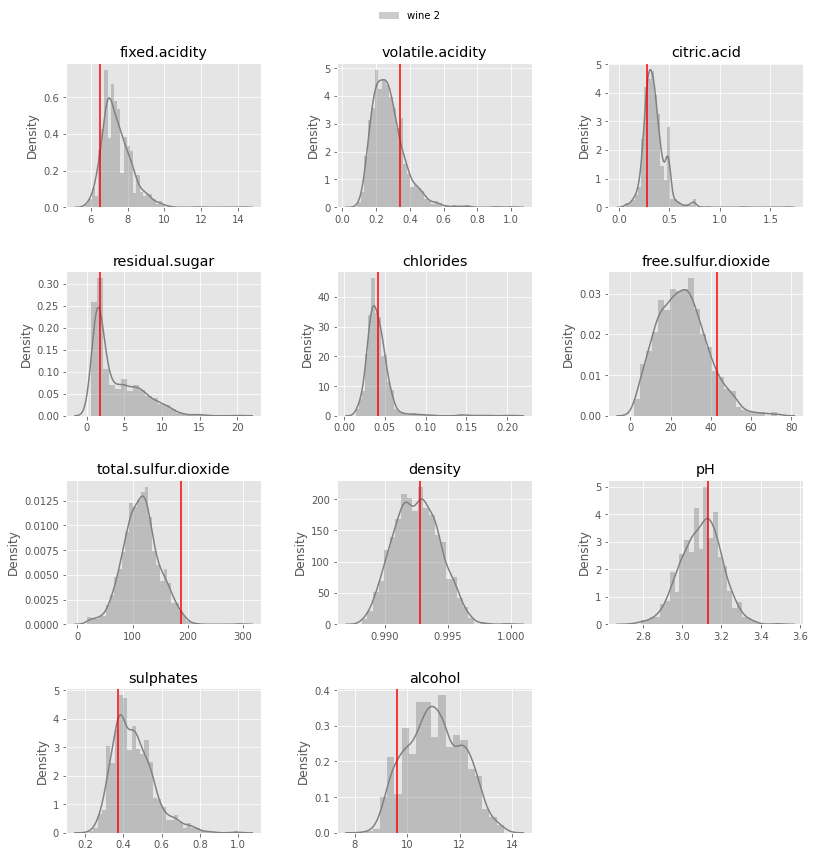

In [ ]:
highest_epis = mc_epistemic[2].argsort()[::-1]
selected_uncertainty = highest_epis[0]
feat_dist_uncert(selected_uncertainty)

uncertainty 205, wine type 1 with the following features:

fixed.acidity             6.2000
volatile.acidity          0.3700
citric.acid               0.3000
residual.sugar            6.6000
chlorides                 0.3460
free.sulfur.dioxide      79.0000
total.sulfur.dioxide    200.0000
density                   0.9954
pH                        3.2900
sulphates                 0.5800
alcohol                   9.6000
Name: 484, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

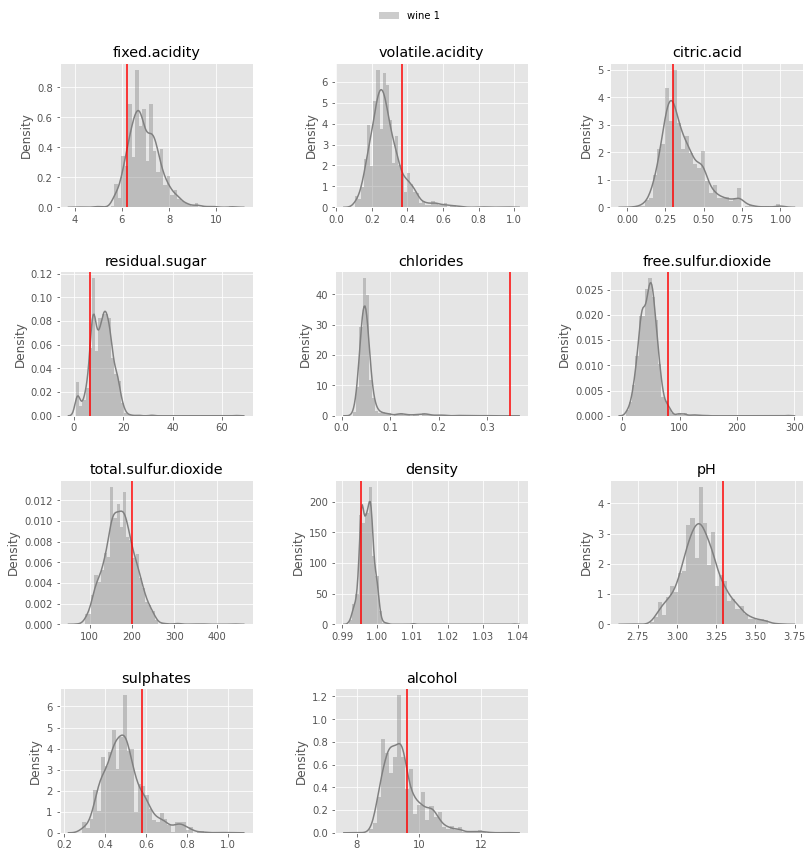

In [ ]:
lowest_epis = mc_epistemic_total[2].argsort()
selected_uncertainty = lowest_epis[0]
feat_dist_uncert(selected_uncertainty)

uncertainty 581, wine type 3 with the following features:

fixed.acidity            6.60000
volatile.acidity         0.17000
citric.acid              0.35000
residual.sugar           2.60000
chlorides                0.03000
free.sulfur.dioxide     33.00000
total.sulfur.dioxide    78.00000
density                  0.99146
pH                       3.22000
sulphates                0.72000
alcohol                 11.30000
Name: 3084, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

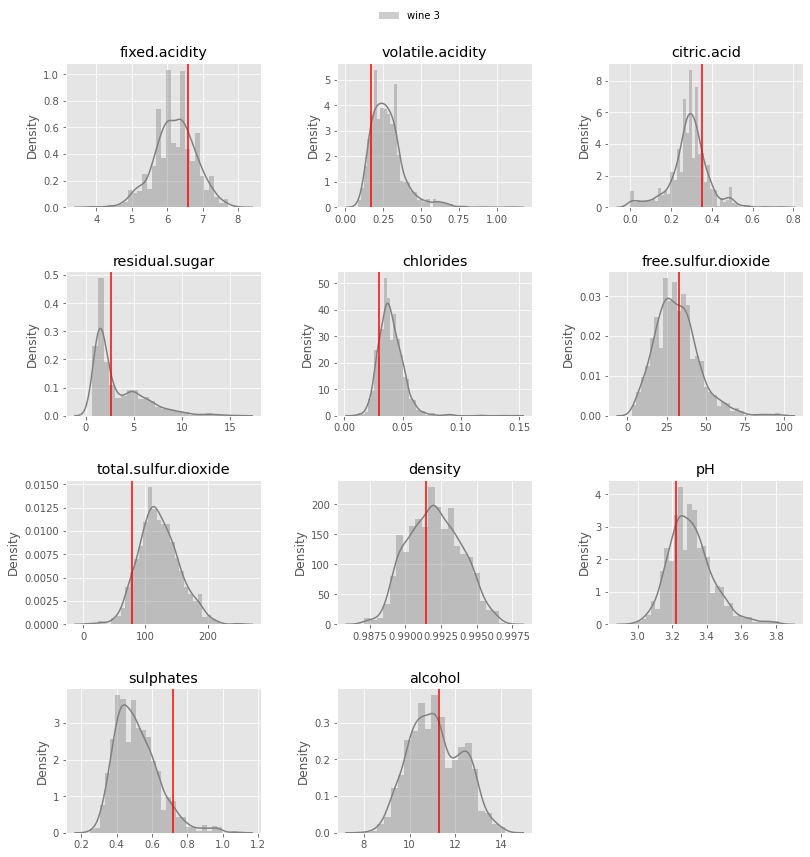

In [ ]:
highest_alea = sigmas_alea_total.argsort()[::-1]
selected_uncertainty = highest_alea[0]
feat_dist_uncert(selected_uncertainty)

uncertainty 205, wine type 1 with the following features:

fixed.acidity             6.2000
volatile.acidity          0.3700
citric.acid               0.3000
residual.sugar            6.6000
chlorides                 0.3460
free.sulfur.dioxide      79.0000
total.sulfur.dioxide    200.0000
density                   0.9954
pH                        3.2900
sulphates                 0.5800
alcohol                   9.6000
Name: 484, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

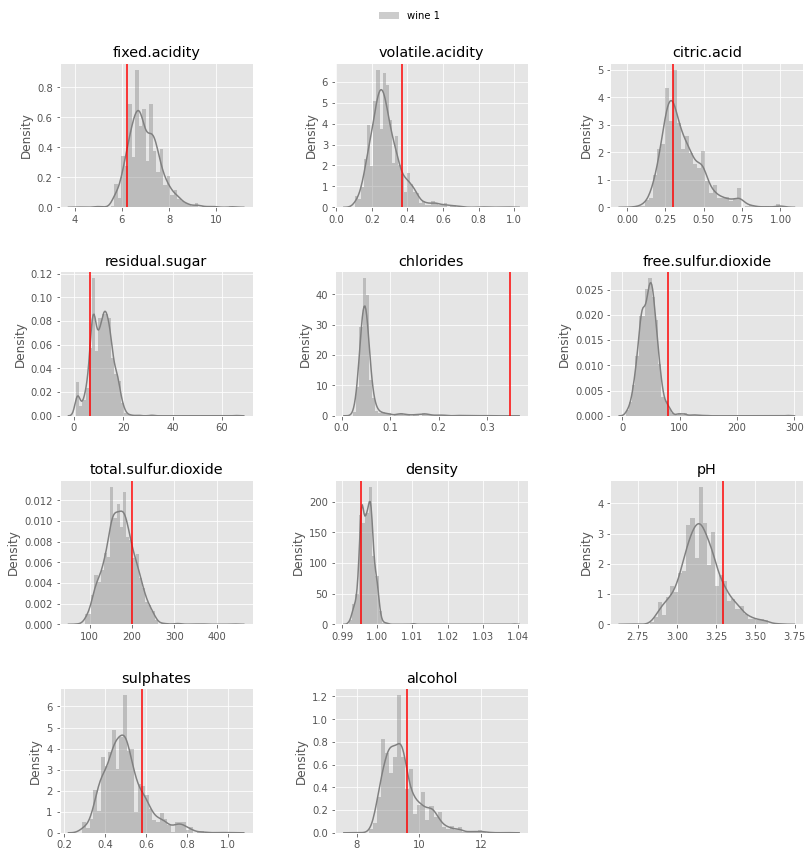

In [ ]:
lowest_alea = sigmas_alea_total.argsort()
selected_uncertainty = lowest_alea[0]
feat_dist_uncert(selected_uncertainty)

# Check loss attenuation

Gal et al. argue that with the provided loss function, the loss for wrongly classified samples is attenuated by giving these predictions high aleatoric uncertainties 

So we ask the question: how many wrongly classified images are among the n predictions with highest aleatoric uncertainty?

In [ ]:
def loss_att_check(sigmas, predicted_class, highest=True, n_alea=20,
                   x_data=X_wine_test):
  #fig, axs = plt.subplots(4, 5, figsize=(8,8)) 
  if highest == True:
    alea_idx = sigmas.argsort()[::-1]
  if highest == False:
    alea_idx = sigmas.argsort()
  # only consider n top aleatoric indices 
  alea_idx = alea_idx[:n_alea]
  # convert predicted 0,1,2,3 to 0,1,7,8
  #converted_pred = np.array([class_converter(i) for i in predicted_class])
  # number and idx of missclassified
  n_wrongclass_highalea = sum(predicted_class[alea_idx] != np.array(y_wine_test_type_original-1)[alea_idx])
  wrongclass_highalea_idx = np.where(predicted_class[alea_idx] != np.array(y_wine_test_type_original-1)[alea_idx])[0]
  # true and predicted labsl of missclassified
  pred_label = (predicted_class[alea_idx])[wrongclass_highalea_idx]
  true_label = (np.array(y_wine_test_type_original-1)[alea_idx])[wrongclass_highalea_idx]
  return n_wrongclass_highalea, alea_idx[wrongclass_highalea_idx], true_label, pred_label

In [ ]:
# 13 missclassifcations
sum(pred_class_alea != np.array(y_wine_test_type_original-1))

13

In [ ]:
# in 980 predictions
pred_class_alea.shape[0]

980

In [ ]:
(n_wrongclass_highalea, alea_idx, 
 true_label, pred_label) = loss_att_check(sigmas_alea, pred_class_alea,
                            n_alea=245) #n_alea=2953)
                            
print(n_wrongclass_highalea, alea_idx, true_label, pred_label)

8 [147 448 770  20 876 908 393 414] [1 1 2 2 2 1 0 2] [0 2 1 1 1 2 2 1]


In [ ]:
n_wrongclass_highalea/sum(pred_class_alea != np.array(y_wine_test_type_original-1))

0.6153846153846154

the above implies that within the top 25% of predictions with highest aleatoric uncertainty, 62% of the misclassified observations were present

# Overlap data points with highest uncertainties when using different models/calculations?

We modeled epistemic and aleatoric uncertainties separately but also jointly. Now let's see if there is an overlap in the predictions with highest uncertainty

## Epistemic

In [ ]:
# checking which samples overlap with the different types of calculating 
# epistemic uncertainty
def overlap_epistemic(all_epi, highest=True, n_epi=20):
    if highest == True:
      epi_0_idx = all_epi[0].argsort()[::-1]
      epi_1_idx = all_epi[1].argsort()[::-1]
      epi_2_idx = all_epi[2].argsort()[::-1]
    if highest == False:
      epi_0_idx = all_epi[0].argsort()
      epi_1_idx = all_epi[1].argsort()
      epi_2_idx = all_epi[2].argsort()
    overlap01 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_1_idx[:n_epi]])))
    overlap12 = list(set.intersection(*map(set, [epi_1_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))   
    overlap02 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))   
    overlap012 = list(set.intersection(*map(set, [epi_0_idx[:n_epi], 
                                               epi_1_idx[:n_epi], 
                                               epi_2_idx[:n_epi]])))
    return overlap01, overlap12, overlap02, overlap012

In [ ]:
# model only epistemic
n_epi = 100
overlap01, overlap12, overlap02, overlap012 = overlap_epistemic(mc_epistemic,
                                                                n_epi=n_epi, highest=False)
print("std max and mean:\n", overlap01,
    "\nstd mean and entropy: \n", overlap12,
    "\nstd max and entropy: \n", overlap02,
    "\nall three:\n", overlap012,
    "\npercentage of all overlap: ", len(overlap012)/n_epi)

std max and mean:
 [512, 2, 12, 13, 21, 22, 537, 540, 542, 550, 563, 52, 60, 61, 69, 592, 81, 614, 616, 629, 638, 128, 653, 654, 657, 658, 662, 153, 154, 672, 674, 162, 684, 174, 700, 193, 194, 706, 201, 715, 204, 205, 209, 215, 216, 223, 228, 230, 742, 763, 256, 768, 777, 782, 270, 788, 276, 790, 279, 289, 802, 291, 293, 296, 814, 817, 342, 353, 355, 868, 874, 885, 887, 902, 391, 910, 402, 918, 408, 423, 935, 425, 937, 426, 949, 439, 440, 955, 956, 959, 450, 459, 460, 974, 463, 472, 479, 496, 502, 506] 
std mean and entropy: 
 [512, 2, 13, 22, 537, 540, 542, 550, 563, 60, 69, 592, 81, 614, 616, 629, 638, 128, 653, 654, 657, 658, 662, 153, 154, 674, 162, 174, 700, 193, 194, 204, 205, 209, 215, 216, 223, 228, 230, 763, 256, 768, 777, 782, 270, 788, 276, 790, 279, 289, 802, 291, 296, 814, 817, 342, 353, 355, 868, 874, 885, 902, 391, 910, 918, 408, 423, 935, 425, 937, 949, 439, 955, 956, 959, 450, 459, 974, 463, 479, 496, 506] 
std max and entropy: 
 [512, 2, 13, 22, 537, 540, 542, 550, 5

In [ ]:
# model both aleatoric and epistemic
n_epi = 100
overlap01, overlap12, overlap02, overlap012 = overlap_epistemic(mc_epistemic_total,
                                                                n_epi=n_epi, highest=False)
print("std max and mean:\n", overlap01,
    "\nstd mean and entropy: \n", overlap12,
    "\nstd max and entropy: \n", overlap02,
    "\nall three:\n", overlap012,
    "\npercentage of all overlap: ", len(overlap012)/n_epi)

std max and mean:
 [512, 2, 12, 13, 22, 537, 540, 542, 550, 563, 69, 583, 588, 592, 81, 94, 614, 616, 622, 629, 128, 653, 654, 657, 658, 662, 154, 674, 162, 168, 684, 686, 174, 175, 691, 190, 193, 713, 202, 201, 204, 205, 209, 210, 215, 228, 230, 231, 744, 748, 752, 763, 768, 256, 777, 782, 270, 788, 790, 802, 291, 293, 296, 810, 814, 817, 322, 835, 838, 334, 335, 342, 865, 353, 355, 868, 368, 884, 885, 887, 902, 910, 918, 423, 424, 935, 434, 950, 439, 955, 956, 959, 459, 460, 974, 472, 479, 492, 496, 506] 
std mean and entropy: 
 [512, 2, 13, 22, 537, 540, 542, 550, 563, 69, 592, 81, 94, 614, 616, 622, 629, 128, 653, 654, 657, 658, 662, 154, 674, 162, 168, 684, 686, 175, 174, 190, 193, 201, 202, 204, 205, 210, 215, 228, 230, 231, 744, 752, 763, 768, 256, 777, 782, 270, 788, 790, 802, 291, 293, 296, 810, 814, 817, 322, 835, 838, 334, 335, 342, 865, 353, 355, 868, 368, 884, 885, 902, 910, 918, 423, 935, 424, 434, 950, 439, 955, 956, 959, 459, 460, 974, 472, 479, 506] 
std max and entrop

## Overlap between models

In [ ]:
def overlap_models(uncertain_1, uncertain_2, highest=True, n=20):
    if highest == True:
      uncertain_1_idx = uncertain_1.argsort()[::-1]
      uncertain_2_idx = uncertain_2.argsort()[::-1]
    if highest == False:
      uncertain_1_idx = uncertain_1.argsort()
      uncertain_2_idx = uncertain_2.argsort()
    overlap = list(set.intersection(*map(set, [uncertain_1_idx[:n], 
                                               uncertain_2_idx[:n]])))
    return overlap

In [ ]:
mc_epistemic[2].shape

(980,)

In [ ]:
# models including epistemic uncertainty 
n = 98
overlap_epi = overlap_models(mc_epistemic[2], mc_epistemic_total[2],
                         n=n)
print("percentage of overlap: ", len(overlap_epi)/n, 
      "\nnumber of overlaps: ", len(overlap_epi),
      "\noverlap:\n", overlap_epi)

percentage of overlap:  0.8571428571428571 
number of overlaps:  84 
overlap:
 [5, 519, 11, 20, 533, 556, 558, 562, 573, 65, 76, 77, 78, 601, 98, 99, 619, 620, 631, 649, 139, 142, 147, 149, 668, 671, 681, 693, 187, 206, 208, 217, 733, 735, 236, 750, 243, 248, 249, 770, 258, 774, 780, 268, 785, 280, 294, 302, 305, 819, 316, 830, 320, 327, 846, 337, 338, 341, 357, 873, 878, 377, 381, 894, 897, 385, 390, 393, 908, 399, 403, 922, 414, 419, 932, 934, 428, 442, 448, 963, 967, 503, 507, 510]


In [ ]:
n = 98
overlap_alea = overlap_models(sigmas_alea, sigmas_alea_total,
                         n=n)
print("percentage of overlap: ", len(overlap_alea)/n, 
      "\nnumber of overlaps: ", len(overlap_alea),
      "\noverlap:\n", overlap_alea)

percentage of overlap:  0.21428571428571427 
number of overlaps:  21 
overlap:
 [5, 520, 143, 144, 915, 534, 663, 409, 667, 159, 800, 934, 53, 699, 830, 711, 341, 105, 760, 121, 639]


# Ranges of uncertainties with different model

In [ ]:
print(f"M1: epistemic uncertainty ranging from {np.min(mc_epistemic[2]):.3} to {np.max(mc_epistemic[2]):.3}")
print(f"M3: epistemic uncertainty ranging from {np.min(mc_epistemic_total[2]):.3} to {np.max(mc_epistemic_total[2]):.3}")

print(f"M2: alearoric uncertainty ranging from {np.min(sigmas_alea):.3} to {np.max(sigmas_alea):.3}")
print(f"M3: aleatoric uncertainty ranging from {np.min(sigmas_alea_total):.3} to {np.max(sigmas_alea_total):.3}")

M1: epistemic uncertainty ranging from 0.0173 to 1.1
M3: epistemic uncertainty ranging from 0.0108 to 1.1
M2: alearoric uncertainty ranging from 0.000817 to 0.578
M3: aleatoric uncertainty ranging from 0.418 to 0.8


# Appendix: Hyperparameter tuning

[64] layers, 64 batch_size, 0.1 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 18ms/step - loss: 0.2680 - accuracy: 0.9278 - val_loss: 0.1307 - val_accuracy: 0.9684
Epoch 2/20
46/46 [==============================] - 1s 17ms/step - loss: 0.1945 - accuracy: 0.9578 - val_loss: 0.0693 - val_accuracy: 0.9786
Epoch 3/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0999 - accuracy: 0.9707 - val_loss: 0.0915 - val_accuracy: 0.9735
Epoch 4/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0819 - accuracy: 0.9752 - val_loss: 0.0692 - val_accuracy: 0.9816
Epoch 5/20
46/46 [==============================] - 1s 16ms/step - loss: 0.1052 - accuracy: 0.9731 - val_loss: 0.1460 - val_accuracy: 0.9735
Epoch 6/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0838 - accuracy: 0.9745 - val_loss: 0.0627 - val_accuracy: 0.9786
Epoch 7/20
46/46 [==============================] - 1s 16ms/step - loss: 0.0941 - accuracy: 0.9792 - val_los

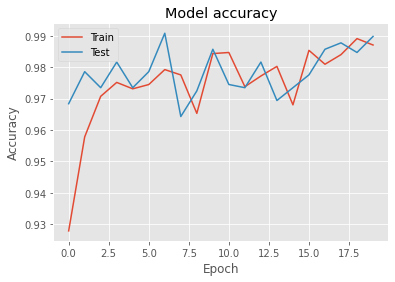

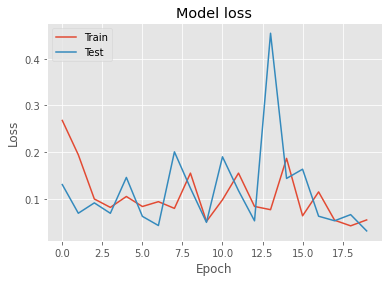

done with 0th training loop

[64] layers, 64 batch_size, 0.01 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 17ms/step - loss: 0.2057 - accuracy: 0.9360 - val_loss: 0.0648 - val_accuracy: 0.9837
Epoch 2/20
46/46 [==============================] - 1s 16ms/step - loss: 0.0669 - accuracy: 0.9796 - val_loss: 0.0461 - val_accuracy: 0.9857
Epoch 3/20
46/46 [==============================] - 1s 16ms/step - loss: 0.0469 - accuracy: 0.9864 - val_loss: 0.0390 - val_accuracy: 0.9878
Epoch 4/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0352 - accuracy: 0.9915 - val_loss: 0.0322 - val_accuracy: 0.9878
Epoch 5/20
46/46 [==============================] - 1s 17ms/step - loss: 0.0363 - accuracy: 0.9874 - val_loss: 0.0426 - val_accuracy: 0.9796
Epoch 6/20
46/46 [==============================] - 1s 16ms/step - loss: 0.0289 - accuracy: 0.9918 - val_loss: 0.0251 - val_accuracy: 0.9888
Epoch 7/20
46/46 [==============================] - 1s 17ms/step - loss: 0.024

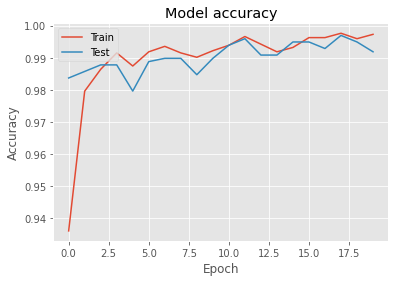

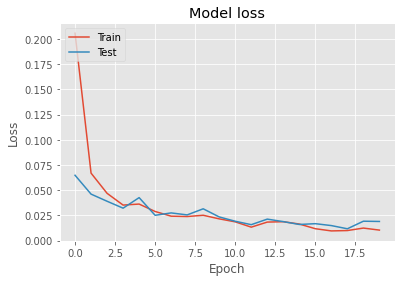

done with 1th training loop

[64] layers, 64 batch_size, 0.001 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 17ms/step - loss: 0.9899 - accuracy: 0.5368 - val_loss: 0.6518 - val_accuracy: 0.8520
Epoch 2/20
46/46 [==============================] - 1s 16ms/step - loss: 0.5110 - accuracy: 0.8965 - val_loss: 0.3824 - val_accuracy: 0.9306
Epoch 3/20
46/46 [==============================] - 1s 17ms/step - loss: 0.3338 - accuracy: 0.9442 - val_loss: 0.2689 - val_accuracy: 0.9561
Epoch 4/20
46/46 [==============================] - 1s 17ms/step - loss: 0.2474 - accuracy: 0.9663 - val_loss: 0.2069 - val_accuracy: 0.9684
Epoch 5/20
46/46 [==============================] - 1s 17ms/step - loss: 0.1967 - accuracy: 0.9711 - val_loss: 0.1679 - val_accuracy: 0.9735
Epoch 6/20
46/46 [==============================] - 1s 17ms/step - loss: 0.1640 - accuracy: 0.9782 - val_loss: 0.1423 - val_accuracy: 0.9755
Epoch 7/20
46/46 [==============================] - 1s 16ms/step - loss: 0.14

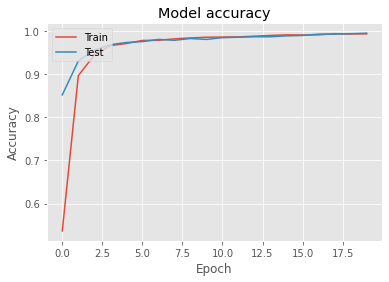

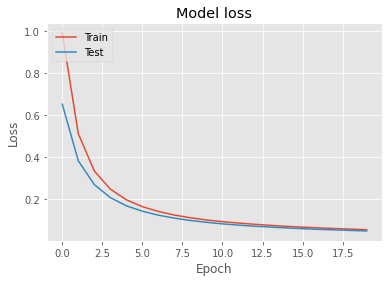

done with 2th training loop

[64] layers, 128 batch_size, 0.1 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 23ms/step - loss: 0.1866 - accuracy: 0.9231 - val_loss: 0.1506 - val_accuracy: 0.9714
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 0.1165 - accuracy: 0.9690 - val_loss: 0.0994 - val_accuracy: 0.9755
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 0.1747 - accuracy: 0.9656 - val_loss: 0.1086 - val_accuracy: 0.9735
Epoch 4/20
23/23 [==============================] - 0s 17ms/step - loss: 0.0905 - accuracy: 0.9782 - val_loss: 0.1356 - val_accuracy: 0.9745
Epoch 5/20
23/23 [==============================] - 0s 17ms/step - loss: 0.0747 - accuracy: 0.9820 - val_loss: 0.1414 - val_accuracy: 0.9735
Epoch 6/20
23/23 [==============================] - 0s 17ms/step - loss: 0.0682 - accuracy: 0.9806 - val_loss: 0.0993 - val_accuracy: 0.9755
Epoch 7/20
23/23 [==============================] - 0s 17ms/step - loss: 0.056

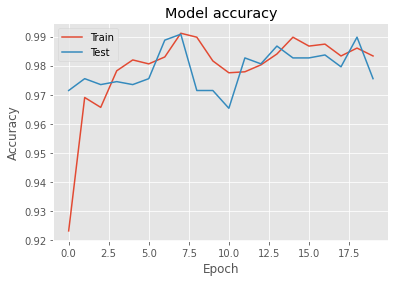

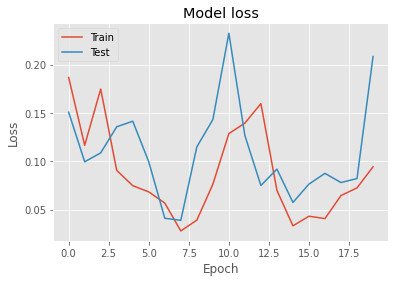

done with 3th training loop

[64] layers, 128 batch_size, 0.01 learning_rate
Epoch 1/20
23/23 [==============================] - 0s 19ms/step - loss: 0.4094 - accuracy: 0.8567 - val_loss: 0.1153 - val_accuracy: 0.9827
Epoch 2/20
23/23 [==============================] - 0s 17ms/step - loss: 0.0951 - accuracy: 0.9779 - val_loss: 0.0666 - val_accuracy: 0.9847
Epoch 3/20
23/23 [==============================] - 0s 17ms/step - loss: 0.0669 - accuracy: 0.9816 - val_loss: 0.0475 - val_accuracy: 0.9918
Epoch 4/20
23/23 [==============================] - 0s 18ms/step - loss: 0.0522 - accuracy: 0.9867 - val_loss: 0.0413 - val_accuracy: 0.9898
Epoch 5/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0425 - accuracy: 0.9908 - val_loss: 0.0380 - val_accuracy: 0.9939
Epoch 6/20
23/23 [==============================] - 0s 17ms/step - loss: 0.0373 - accuracy: 0.9922 - val_loss: 0.0293 - val_accuracy: 0.9969
Epoch 7/20
23/23 [==============================] - 0s 17ms/step - loss: 0.03

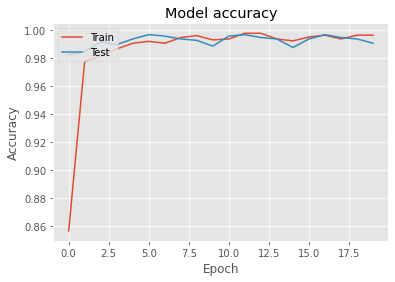

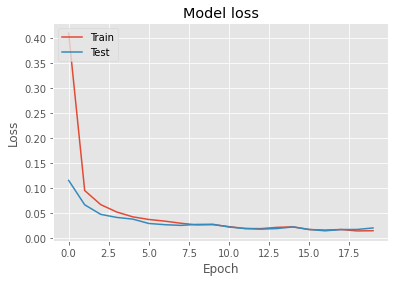

done with 4th training loop

[64] layers, 128 batch_size, 0.001 learning_rate
Epoch 1/20
23/23 [==============================] - 0s 19ms/step - loss: 1.0732 - accuracy: 0.4789 - val_loss: 0.8504 - val_accuracy: 0.7296
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 0.7223 - accuracy: 0.7999 - val_loss: 0.5923 - val_accuracy: 0.8806
Epoch 3/20
23/23 [==============================] - 0s 18ms/step - loss: 0.5205 - accuracy: 0.8897 - val_loss: 0.4354 - val_accuracy: 0.9194
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 0.3967 - accuracy: 0.9295 - val_loss: 0.3364 - val_accuracy: 0.9490
Epoch 5/20
23/23 [==============================] - 0s 17ms/step - loss: 0.3165 - accuracy: 0.9442 - val_loss: 0.2732 - val_accuracy: 0.9602
Epoch 6/20
23/23 [==============================] - 0s 17ms/step - loss: 0.2632 - accuracy: 0.9554 - val_loss: 0.2298 - val_accuracy: 0.9653
Epoch 7/20
23/23 [==============================] - 0s 18ms/step - loss: 0.2

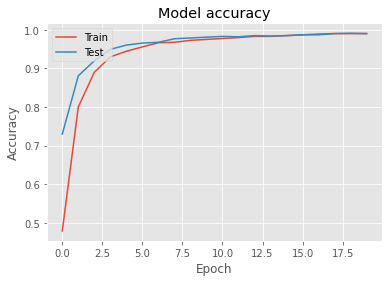

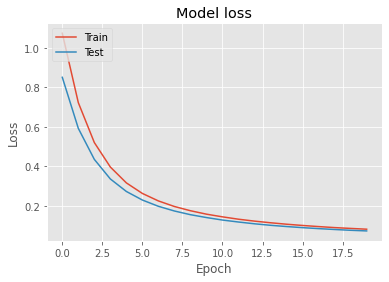

done with 5th training loop

[64, 64] layers, 64 batch_size, 0.1 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 21ms/step - loss: 0.3071 - accuracy: 0.9112 - val_loss: 0.0928 - val_accuracy: 0.9663
Epoch 2/20
46/46 [==============================] - 1s 19ms/step - loss: 0.1636 - accuracy: 0.9571 - val_loss: 0.0682 - val_accuracy: 0.9755
Epoch 3/20
46/46 [==============================] - 1s 23ms/step - loss: 0.1099 - accuracy: 0.9673 - val_loss: 0.0523 - val_accuracy: 0.9806
Epoch 4/20
46/46 [==============================] - 1s 19ms/step - loss: 0.1060 - accuracy: 0.9741 - val_loss: 0.1678 - val_accuracy: 0.9480
Epoch 5/20
46/46 [==============================] - 1s 19ms/step - loss: 0.1177 - accuracy: 0.9677 - val_loss: 0.2298 - val_accuracy: 0.9520
Epoch 6/20
46/46 [==============================] - 1s 19ms/step - loss: 0.1735 - accuracy: 0.9588 - val_loss: 0.0878 - val_accuracy: 0.9745
Epoch 7/20
46/46 [==============================] - 1s 19ms/step - loss: 0.

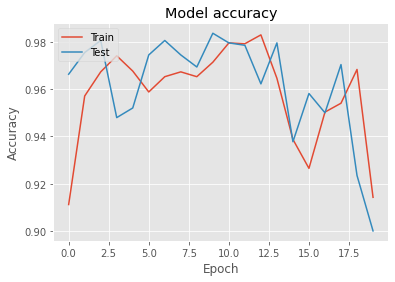

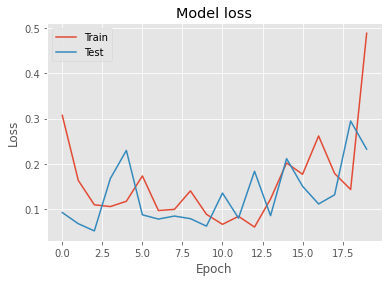

done with 6th training loop

[64, 64] layers, 64 batch_size, 0.01 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 19ms/step - loss: 0.2135 - accuracy: 0.9221 - val_loss: 0.0622 - val_accuracy: 0.9755
Epoch 2/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0604 - accuracy: 0.9769 - val_loss: 0.0329 - val_accuracy: 0.9878
Epoch 3/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0465 - accuracy: 0.9796 - val_loss: 0.0343 - val_accuracy: 0.9867
Epoch 4/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0401 - accuracy: 0.9854 - val_loss: 0.0294 - val_accuracy: 0.9857
Epoch 5/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0357 - accuracy: 0.9877 - val_loss: 0.0356 - val_accuracy: 0.9837
Epoch 6/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0698 - accuracy: 0.9762 - val_loss: 0.0542 - val_accuracy: 0.9765
Epoch 7/20
46/46 [==============================] - 1s 19ms/step - loss: 0

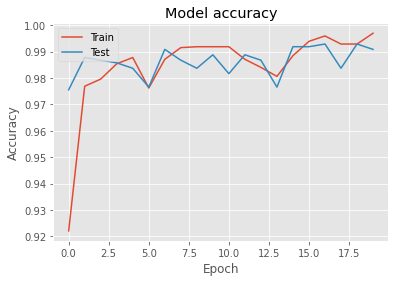

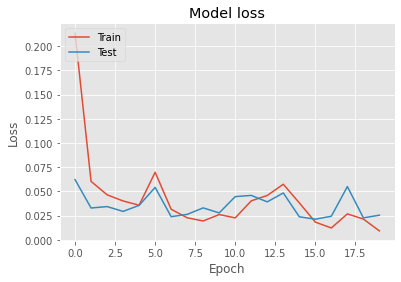

done with 7th training loop

[64, 64] layers, 64 batch_size, 0.001 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 20ms/step - loss: 0.5767 - accuracy: 0.8417 - val_loss: 0.2895 - val_accuracy: 0.9327
Epoch 2/20
46/46 [==============================] - 1s 19ms/step - loss: 0.2002 - accuracy: 0.9568 - val_loss: 0.1314 - val_accuracy: 0.9796
Epoch 3/20
46/46 [==============================] - 1s 19ms/step - loss: 0.1112 - accuracy: 0.9748 - val_loss: 0.0867 - val_accuracy: 0.9827
Epoch 4/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0813 - accuracy: 0.9816 - val_loss: 0.0635 - val_accuracy: 0.9898
Epoch 5/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0656 - accuracy: 0.9860 - val_loss: 0.0525 - val_accuracy: 0.9918
Epoch 6/20
46/46 [==============================] - 1s 19ms/step - loss: 0.0524 - accuracy: 0.9901 - val_loss: 0.0474 - val_accuracy: 0.9857
Epoch 7/20
46/46 [==============================] - 1s 20ms/step - loss: 

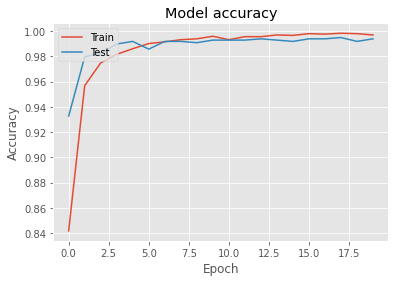

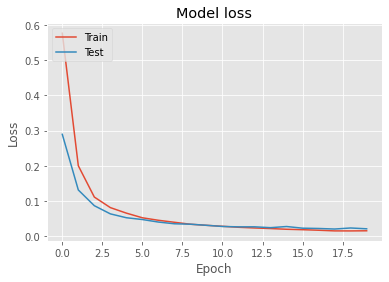

done with 8th training loop

[64, 64] layers, 128 batch_size, 0.1 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 22ms/step - loss: 0.3341 - accuracy: 0.8904 - val_loss: 0.0918 - val_accuracy: 0.9663
Epoch 2/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0946 - accuracy: 0.9649 - val_loss: 0.0510 - val_accuracy: 0.9847
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0829 - accuracy: 0.9748 - val_loss: 0.0993 - val_accuracy: 0.9633
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0796 - accuracy: 0.9758 - val_loss: 0.0728 - val_accuracy: 0.9724
Epoch 5/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0589 - accuracy: 0.9806 - val_loss: 0.0589 - val_accuracy: 0.9827
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0989 - accuracy: 0.9738 - val_loss: 0.0452 - val_accuracy: 0.9816
Epoch 7/20
23/23 [==============================] - 0s 20ms/step - loss: 0

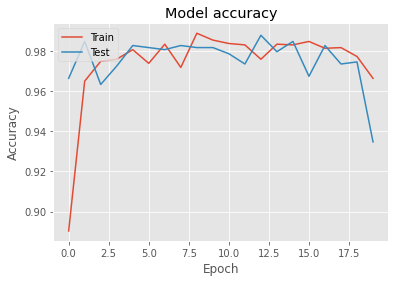

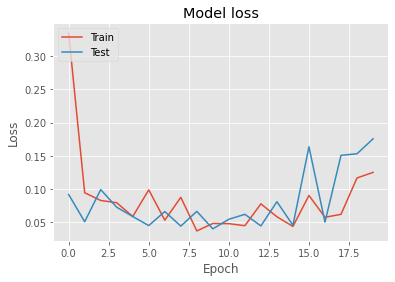

done with 9th training loop

[64, 64] layers, 128 batch_size, 0.01 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 22ms/step - loss: 0.2393 - accuracy: 0.9159 - val_loss: 0.0574 - val_accuracy: 0.9724
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 0.0483 - accuracy: 0.9806 - val_loss: 0.0379 - val_accuracy: 0.9806
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0446 - accuracy: 0.9837 - val_loss: 0.1194 - val_accuracy: 0.9673
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0648 - accuracy: 0.9772 - val_loss: 0.0268 - val_accuracy: 0.9867
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0357 - accuracy: 0.9860 - val_loss: 0.0527 - val_accuracy: 0.9765
Epoch 6/20
23/23 [==============================] - 0s 20ms/step - loss: 0.0374 - accuracy: 0.9840 - val_loss: 0.0570 - val_accuracy: 0.9755
Epoch 7/20
23/23 [==============================] - 0s 21ms/step - loss: 

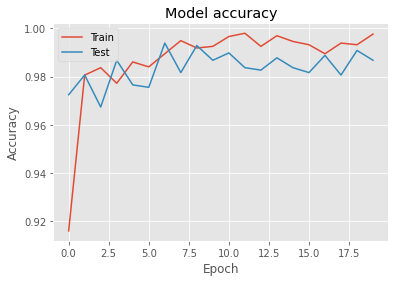

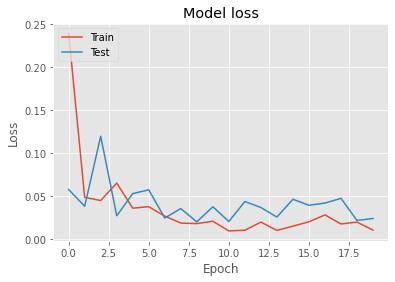

done with 10th training loop

[64, 64] layers, 128 batch_size, 0.001 learning_rate
Epoch 1/20
23/23 [==============================] - 0s 21ms/step - loss: 0.8625 - accuracy: 0.7049 - val_loss: 0.6220 - val_accuracy: 0.8633
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 0.4752 - accuracy: 0.8999 - val_loss: 0.3212 - val_accuracy: 0.9378
Epoch 3/20
23/23 [==============================] - 0s 20ms/step - loss: 0.2608 - accuracy: 0.9459 - val_loss: 0.1878 - val_accuracy: 0.9684
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 0.1661 - accuracy: 0.9677 - val_loss: 0.1285 - val_accuracy: 0.9786
Epoch 5/20
23/23 [==============================] - 0s 21ms/step - loss: 0.1198 - accuracy: 0.9779 - val_loss: 0.0988 - val_accuracy: 0.9796
Epoch 6/20
23/23 [==============================] - 1s 23ms/step - loss: 0.0949 - accuracy: 0.9823 - val_loss: 0.0817 - val_accuracy: 0.9837
Epoch 7/20
23/23 [==============================] - 0s 20ms/step - loss

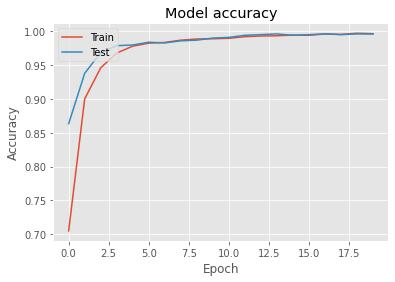

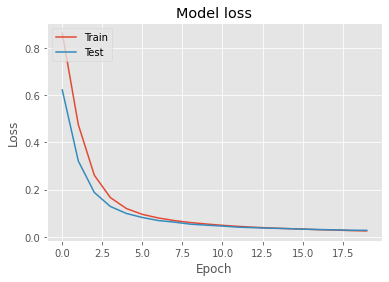

done with 11th training loop

[32, 32] layers, 64 batch_size, 0.1 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 21ms/step - loss: 0.2422 - accuracy: 0.9159 - val_loss: 0.0768 - val_accuracy: 0.9745
Epoch 2/20
46/46 [==============================] - 1s 20ms/step - loss: 0.1463 - accuracy: 0.9626 - val_loss: 0.1125 - val_accuracy: 0.9714
Epoch 3/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0930 - accuracy: 0.9660 - val_loss: 0.0561 - val_accuracy: 0.9806
Epoch 4/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0649 - accuracy: 0.9782 - val_loss: 0.0671 - val_accuracy: 0.9704
Epoch 5/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0537 - accuracy: 0.9809 - val_loss: 0.0417 - val_accuracy: 0.9867
Epoch 6/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0527 - accuracy: 0.9789 - val_loss: 0.0669 - val_accuracy: 0.9735
Epoch 7/20
46/46 [==============================] - 1s 20ms/step - loss: 0

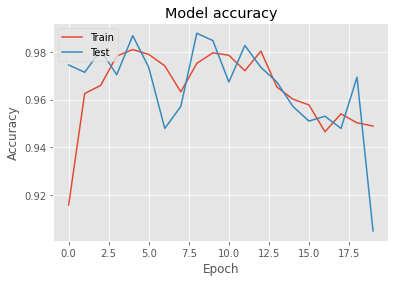

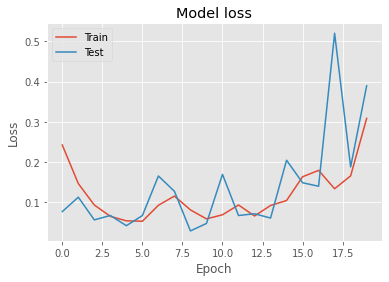

done with 12th training loop

[32, 32] layers, 64 batch_size, 0.01 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 22ms/step - loss: 0.2618 - accuracy: 0.9030 - val_loss: 0.0980 - val_accuracy: 0.9612
Epoch 2/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0615 - accuracy: 0.9762 - val_loss: 0.0521 - val_accuracy: 0.9786
Epoch 3/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0520 - accuracy: 0.9769 - val_loss: 0.0544 - val_accuracy: 0.9694
Epoch 4/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0421 - accuracy: 0.9833 - val_loss: 0.0401 - val_accuracy: 0.9837
Epoch 5/20
46/46 [==============================] - 1s 20ms/step - loss: 0.0313 - accuracy: 0.9884 - val_loss: 0.0392 - val_accuracy: 0.9878
Epoch 6/20
46/46 [==============================] - 1s 21ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0343 - val_accuracy: 0.9857
Epoch 7/20
46/46 [==============================] - 1s 20ms/step - loss: 

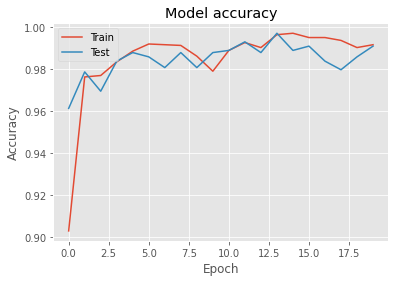

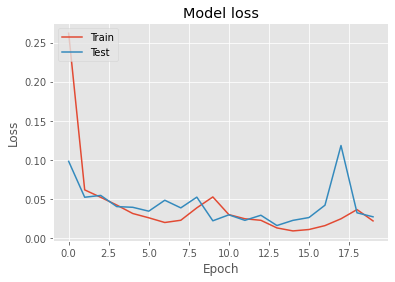

done with 13th training loop

[32, 32] layers, 64 batch_size, 0.001 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 21ms/step - loss: 0.9463 - accuracy: 0.6031 - val_loss: 0.6744 - val_accuracy: 0.8561
Epoch 2/20
46/46 [==============================] - 1s 20ms/step - loss: 0.4766 - accuracy: 0.8955 - val_loss: 0.3131 - val_accuracy: 0.9153
Epoch 3/20
46/46 [==============================] - 1s 23ms/step - loss: 0.2473 - accuracy: 0.9425 - val_loss: 0.1800 - val_accuracy: 0.9561
Epoch 4/20
46/46 [==============================] - 1s 21ms/step - loss: 0.1596 - accuracy: 0.9609 - val_loss: 0.1251 - val_accuracy: 0.9704
Epoch 5/20
46/46 [==============================] - 1s 22ms/step - loss: 0.1192 - accuracy: 0.9765 - val_loss: 0.0995 - val_accuracy: 0.9704
Epoch 6/20
46/46 [==============================] - 1s 21ms/step - loss: 0.0961 - accuracy: 0.9769 - val_loss: 0.0816 - val_accuracy: 0.9816
Epoch 7/20
46/46 [==============================] - 1s 25ms/step - loss:

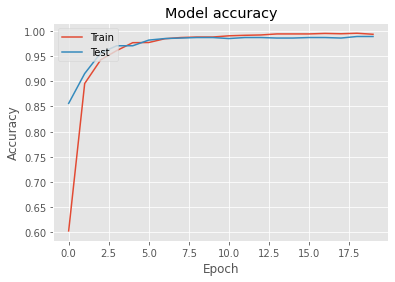

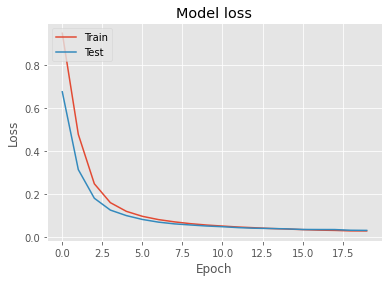

done with 14th training loop

[32, 32] layers, 128 batch_size, 0.1 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 23ms/step - loss: 0.3035 - accuracy: 0.9037 - val_loss: 0.1108 - val_accuracy: 0.9673
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0830 - accuracy: 0.9711 - val_loss: 0.0378 - val_accuracy: 0.9827
Epoch 3/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0751 - accuracy: 0.9769 - val_loss: 0.0355 - val_accuracy: 0.9888
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0757 - accuracy: 0.9816 - val_loss: 0.0802 - val_accuracy: 0.9806
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0449 - accuracy: 0.9864 - val_loss: 0.0589 - val_accuracy: 0.9776
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0358 - accuracy: 0.9864 - val_loss: 0.0233 - val_accuracy: 0.9918
Epoch 7/20
23/23 [==============================] - 1s 22ms/step - loss: 

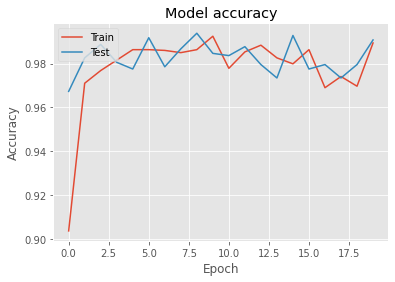

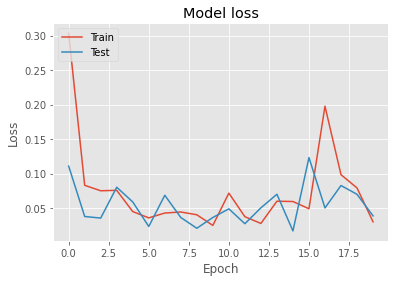

done with 15th training loop

[32, 32] layers, 128 batch_size, 0.01 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 23ms/step - loss: 0.3912 - accuracy: 0.8819 - val_loss: 0.0794 - val_accuracy: 0.9765
Epoch 2/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0728 - accuracy: 0.9711 - val_loss: 0.0792 - val_accuracy: 0.9653
Epoch 3/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0519 - accuracy: 0.9792 - val_loss: 0.0277 - val_accuracy: 0.9918
Epoch 4/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0358 - accuracy: 0.9864 - val_loss: 0.0258 - val_accuracy: 0.9918
Epoch 5/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0285 - accuracy: 0.9905 - val_loss: 0.0355 - val_accuracy: 0.9847
Epoch 6/20
23/23 [==============================] - 0s 21ms/step - loss: 0.0274 - accuracy: 0.9905 - val_loss: 0.0252 - val_accuracy: 0.9918
Epoch 7/20
23/23 [==============================] - 0s 22ms/step - loss:

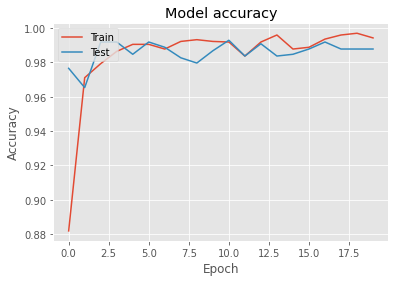

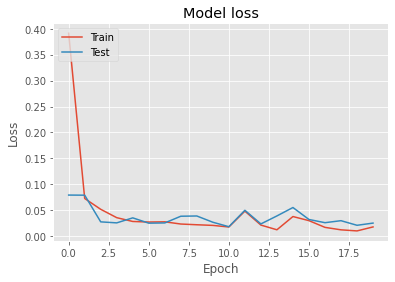

done with 16th training loop

[32, 32] layers, 128 batch_size, 0.001 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 24ms/step - loss: 0.9988 - accuracy: 0.4935 - val_loss: 0.8632 - val_accuracy: 0.6898
Epoch 2/20
23/23 [==============================] - 1s 25ms/step - loss: 0.7632 - accuracy: 0.7481 - val_loss: 0.6409 - val_accuracy: 0.7959
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 0.5435 - accuracy: 0.8465 - val_loss: 0.4319 - val_accuracy: 0.8980
Epoch 4/20
23/23 [==============================] - 1s 22ms/step - loss: 0.3561 - accuracy: 0.9224 - val_loss: 0.2796 - val_accuracy: 0.9378
Epoch 5/20
23/23 [==============================] - 1s 25ms/step - loss: 0.2367 - accuracy: 0.9520 - val_loss: 0.1969 - val_accuracy: 0.9480
Epoch 6/20
23/23 [==============================] - 0s 22ms/step - loss: 0.1719 - accuracy: 0.9673 - val_loss: 0.1508 - val_accuracy: 0.9633
Epoch 7/20
23/23 [==============================] - 1s 27ms/step - loss

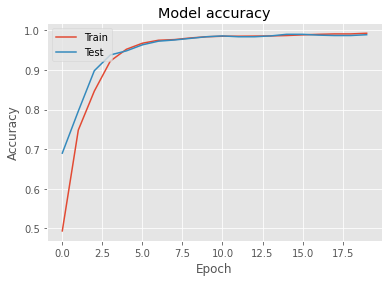

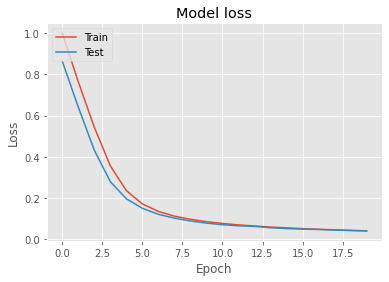

done with 17th training loop

[32, 64, 32] layers, 64 batch_size, 0.1 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 24ms/step - loss: 0.3987 - accuracy: 0.8781 - val_loss: 0.1764 - val_accuracy: 0.9510
Epoch 2/20
46/46 [==============================] - 1s 26ms/step - loss: 0.1126 - accuracy: 0.9622 - val_loss: 0.0620 - val_accuracy: 0.9673
Epoch 3/20
46/46 [==============================] - 1s 27ms/step - loss: 0.1239 - accuracy: 0.9656 - val_loss: 0.0945 - val_accuracy: 0.9633
Epoch 4/20
46/46 [==============================] - 1s 24ms/step - loss: 0.2052 - accuracy: 0.9421 - val_loss: 0.1433 - val_accuracy: 0.9510
Epoch 5/20
46/46 [==============================] - 1s 25ms/step - loss: 0.1083 - accuracy: 0.9626 - val_loss: 0.0834 - val_accuracy: 0.9673
Epoch 6/20
46/46 [==============================] - 1s 27ms/step - loss: 0.1347 - accuracy: 0.9554 - val_loss: 0.0683 - val_accuracy: 0.9735
Epoch 7/20
46/46 [==============================] - 1s 23ms/step - los

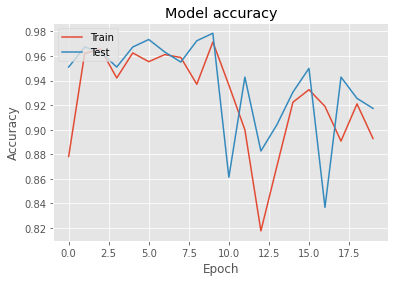

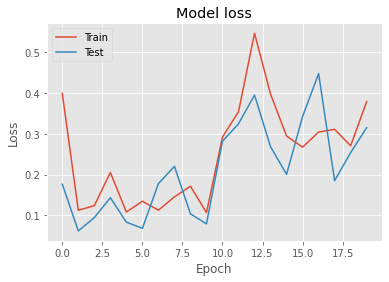

done with 18th training loop

[32, 64, 32] layers, 64 batch_size, 0.01 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 28ms/step - loss: 0.2248 - accuracy: 0.9135 - val_loss: 0.0567 - val_accuracy: 0.9755
Epoch 2/20
46/46 [==============================] - 1s 23ms/step - loss: 0.0685 - accuracy: 0.9728 - val_loss: 0.0380 - val_accuracy: 0.9786
Epoch 3/20
46/46 [==============================] - 1s 24ms/step - loss: 0.0488 - accuracy: 0.9826 - val_loss: 0.0375 - val_accuracy: 0.9806
Epoch 4/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0559 - accuracy: 0.9775 - val_loss: 0.0477 - val_accuracy: 0.9806
Epoch 5/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0406 - accuracy: 0.9843 - val_loss: 0.0314 - val_accuracy: 0.9867
Epoch 6/20
46/46 [==============================] - 1s 23ms/step - loss: 0.0230 - accuracy: 0.9915 - val_loss: 0.0309 - val_accuracy: 0.9888
Epoch 7/20
46/46 [==============================] - 1s 23ms/step - lo

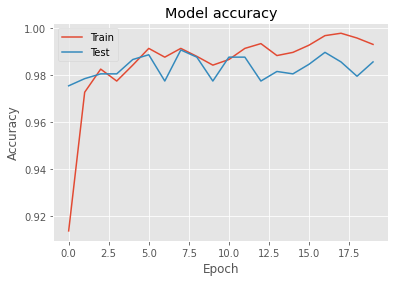

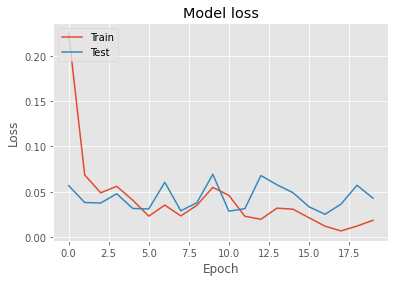

done with 19th training loop

[32, 64, 32] layers, 64 batch_size, 0.001 learning_rate
Epoch 1/20
46/46 [==============================] - 1s 27ms/step - loss: 0.7555 - accuracy: 0.7124 - val_loss: 0.4481 - val_accuracy: 0.8541
Epoch 2/20
46/46 [==============================] - 1s 24ms/step - loss: 0.2932 - accuracy: 0.9061 - val_loss: 0.1677 - val_accuracy: 0.9449
Epoch 3/20
46/46 [==============================] - 1s 23ms/step - loss: 0.1338 - accuracy: 0.9585 - val_loss: 0.0925 - val_accuracy: 0.9684
Epoch 4/20
46/46 [==============================] - 1s 23ms/step - loss: 0.0851 - accuracy: 0.9765 - val_loss: 0.0685 - val_accuracy: 0.9755
Epoch 5/20
46/46 [==============================] - 1s 27ms/step - loss: 0.0645 - accuracy: 0.9823 - val_loss: 0.0545 - val_accuracy: 0.9765
Epoch 6/20
46/46 [==============================] - 1s 24ms/step - loss: 0.0513 - accuracy: 0.9881 - val_loss: 0.0485 - val_accuracy: 0.9837
Epoch 7/20
46/46 [==============================] - 1s 24ms/step - l

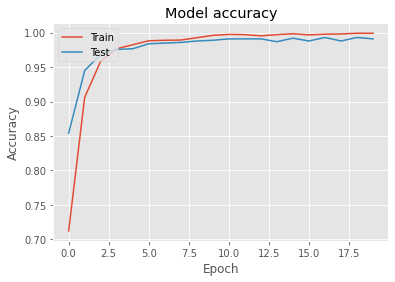

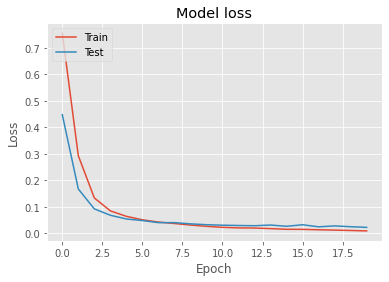

done with 20th training loop

[32, 64, 32] layers, 128 batch_size, 0.1 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 29ms/step - loss: 0.6489 - accuracy: 0.7852 - val_loss: 0.1557 - val_accuracy: 0.9745
Epoch 2/20
23/23 [==============================] - 1s 27ms/step - loss: 0.1273 - accuracy: 0.9585 - val_loss: 0.1734 - val_accuracy: 0.9602
Epoch 3/20
23/23 [==============================] - 1s 27ms/step - loss: 0.1327 - accuracy: 0.9680 - val_loss: 0.0569 - val_accuracy: 0.9776
Epoch 4/20
23/23 [==============================] - 1s 27ms/step - loss: 0.0622 - accuracy: 0.9799 - val_loss: 0.0497 - val_accuracy: 0.9786
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0460 - accuracy: 0.9850 - val_loss: 0.0332 - val_accuracy: 0.9837
Epoch 6/20
23/23 [==============================] - 1s 28ms/step - loss: 0.0629 - accuracy: 0.9813 - val_loss: 0.0561 - val_accuracy: 0.9776
Epoch 7/20
23/23 [==============================] - 1s 27ms/step - lo

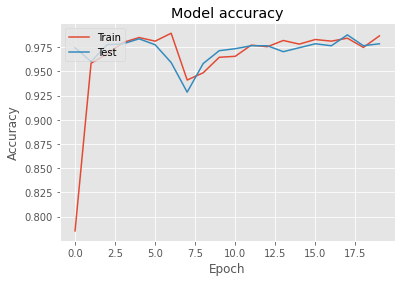

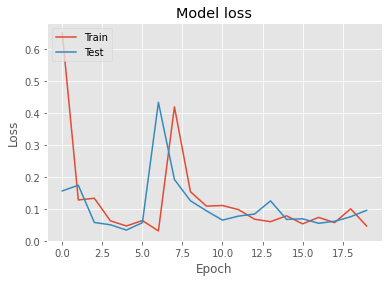

done with 21th training loop

[32, 64, 32] layers, 128 batch_size, 0.01 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 26ms/step - loss: 0.2866 - accuracy: 0.8914 - val_loss: 0.0732 - val_accuracy: 0.9663
Epoch 2/20
23/23 [==============================] - 1s 27ms/step - loss: 0.0794 - accuracy: 0.9711 - val_loss: 0.0552 - val_accuracy: 0.9776
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0502 - accuracy: 0.9809 - val_loss: 0.0478 - val_accuracy: 0.9806
Epoch 4/20
23/23 [==============================] - 1s 27ms/step - loss: 0.0325 - accuracy: 0.9888 - val_loss: 0.0290 - val_accuracy: 0.9867
Epoch 5/20
23/23 [==============================] - 1s 25ms/step - loss: 0.0297 - accuracy: 0.9884 - val_loss: 0.0513 - val_accuracy: 0.9806
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0292 - accuracy: 0.9884 - val_loss: 0.0410 - val_accuracy: 0.9857
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - l

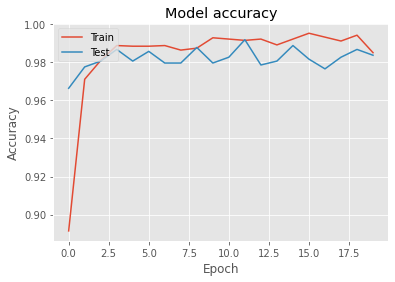

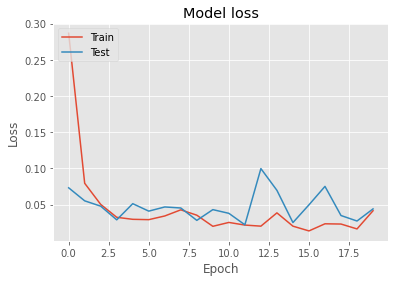

done with 22th training loop

[32, 64, 32] layers, 128 batch_size, 0.001 learning_rate
Epoch 1/20
23/23 [==============================] - 1s 29ms/step - loss: 0.9484 - accuracy: 0.5300 - val_loss: 0.7516 - val_accuracy: 0.6663
Epoch 2/20
23/23 [==============================] - 1s 28ms/step - loss: 0.6103 - accuracy: 0.7665 - val_loss: 0.4559 - val_accuracy: 0.8724
Epoch 3/20
23/23 [==============================] - 1s 24ms/step - loss: 0.3517 - accuracy: 0.9095 - val_loss: 0.2464 - val_accuracy: 0.9418
Epoch 4/20
23/23 [==============================] - 1s 27ms/step - loss: 0.1937 - accuracy: 0.9510 - val_loss: 0.1551 - val_accuracy: 0.9541
Epoch 5/20
23/23 [==============================] - 1s 25ms/step - loss: 0.1293 - accuracy: 0.9602 - val_loss: 0.1119 - val_accuracy: 0.9653
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 0.0970 - accuracy: 0.9690 - val_loss: 0.0883 - val_accuracy: 0.9724
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - 

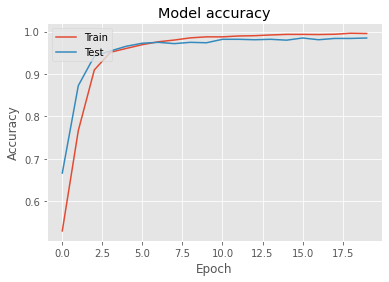

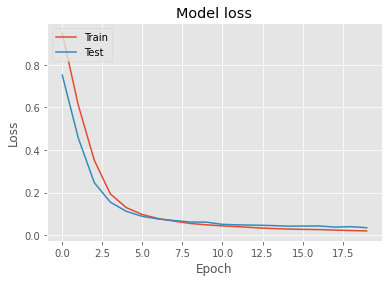

done with 23th training loop



In [ ]:
# [64, 64] layers, 128 batch_size, 0.001 learning_rate

n_hiddens = [[64], [64,64], [32,32], [32,64,32]]
batch_sizes = [64, 128]
learning_rates = [0.1, 0.01, 0.001]

dropout_p = 0.0
num_classes = 3
epochs = 20
input_shape = (11)

for i, (n_hidden, batch_size, learning_rate) in enumerate(product(n_hiddens, batch_sizes, learning_rates)):
  print(f"{n_hidden} layers, {batch_size} batch_size, {learning_rate} learning_rate")

  model_orig = get_model(act="relu", dropout_prob=0.0, 
                          n_hidden=n_hidden,
                          optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
  
  history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_val, y_wine_val_type), 
                       batch_size=batch_size, epochs=epochs, verbose=1)
  
  loss_accuracy_plot(history_model_orig)
  
  save_model(model=model_orig, batch_size=batch_size, 
             n_epochs=epochs, descr="hyptune_winemodel_learningrate" + str(learning_rate*1000), 
             n_hidden=n_hidden, dropout=None)
  print(f"done with {i}th training loop\n")


0.1 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 23ms/step - loss: 4.2012 - accuracy: 0.5701 - val_loss: 3.6642 - val_accuracy: 0.6806
Epoch 2/20
23/23 [==============================] - 1s 23ms/step - loss: 3.2657 - accuracy: 0.7342 - val_loss: 2.8625 - val_accuracy: 0.7816
Epoch 3/20
23/23 [==============================] - 1s 23ms/step - loss: 2.5665 - accuracy: 0.8298 - val_loss: 2.2630 - val_accuracy: 0.8735
Epoch 4/20
23/23 [==============================] - 1s 22ms/step - loss: 2.0438 - accuracy: 0.9027 - val_loss: 1.8061 - val_accuracy: 0.9224
Epoch 5/20
23/23 [==============================] - 0s 20ms/step - loss: 1.6510 - accuracy: 0.9275 - val_loss: 1.4753 - val_accuracy: 0.9367
Epoch 6/20
23/23 [==============================] - 0s 19ms/step - loss: 1.3565 - accuracy: 0.9459 - val_loss: 1.2318 - val_accuracy: 0.9500
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - loss: 1.1474 - accuracy: 0.9489 - val_loss: 1.0430 - val_accuracy: 0.9571

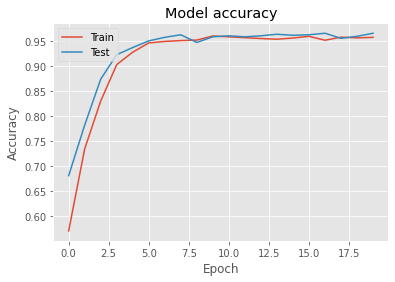

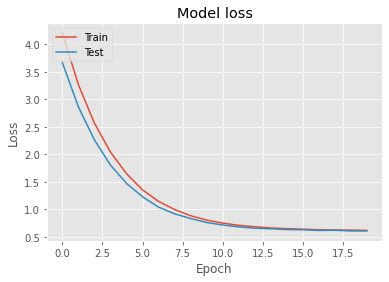

done with 0th training loop

0.15 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 25ms/step - loss: 3.9563 - accuracy: 0.5810 - val_loss: 3.4373 - val_accuracy: 0.7694
Epoch 2/20
23/23 [==============================] - 1s 23ms/step - loss: 3.0742 - accuracy: 0.8319 - val_loss: 2.6840 - val_accuracy: 0.8571
Epoch 3/20
23/23 [==============================] - 1s 23ms/step - loss: 2.4149 - accuracy: 0.8884 - val_loss: 2.1265 - val_accuracy: 0.9163
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 1.9287 - accuracy: 0.9146 - val_loss: 1.6990 - val_accuracy: 0.9378
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 1.5582 - accuracy: 0.9343 - val_loss: 1.3908 - val_accuracy: 0.9296
Epoch 6/20
23/23 [==============================] - 1s 23ms/step - loss: 1.2914 - accuracy: 0.9401 - val_loss: 1.1734 - val_accuracy: 0.9429
Epoch 7/20
23/23 [==============================] - 0s 20ms/step - loss: 1.0911 - accuracy: 0.9483 - val_loss:

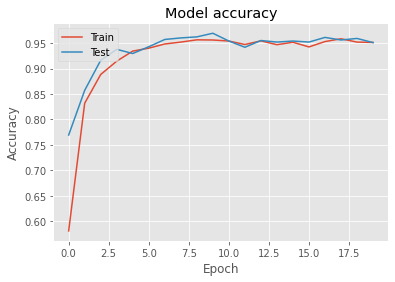

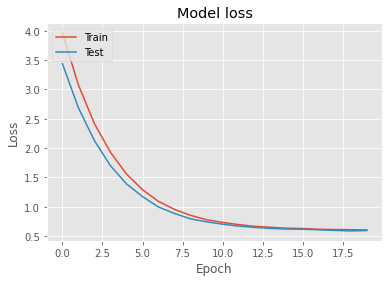

done with 1th training loop

0.2 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 22ms/step - loss: 3.8518 - accuracy: 0.5970 - val_loss: 3.3585 - val_accuracy: 0.7796
Epoch 2/20
23/23 [==============================] - 1s 24ms/step - loss: 2.9839 - accuracy: 0.8363 - val_loss: 2.6095 - val_accuracy: 0.8796
Epoch 3/20
23/23 [==============================] - 0s 20ms/step - loss: 2.3514 - accuracy: 0.8890 - val_loss: 2.0774 - val_accuracy: 0.9071
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 1.8878 - accuracy: 0.9142 - val_loss: 1.6818 - val_accuracy: 0.9255
Epoch 5/20
23/23 [==============================] - 0s 19ms/step - loss: 1.5473 - accuracy: 0.9163 - val_loss: 1.3948 - val_accuracy: 0.9418
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 1.2900 - accuracy: 0.9312 - val_loss: 1.1642 - val_accuracy: 0.9398
Epoch 7/20
23/23 [==============================] - 1s 23ms/step - loss: 1.0995 - accuracy: 0.9381 - val_loss: 

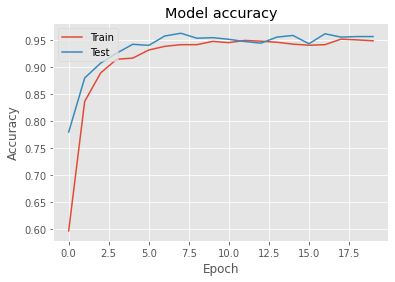

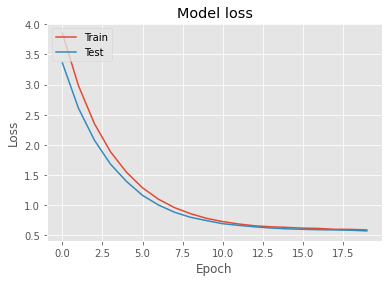

done with 2th training loop

0.25 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 26ms/step - loss: 3.7015 - accuracy: 0.5589 - val_loss: 3.2277 - val_accuracy: 0.6929
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 2.9013 - accuracy: 0.7638 - val_loss: 2.5715 - val_accuracy: 0.7929
Epoch 3/20
23/23 [==============================] - 1s 23ms/step - loss: 2.3193 - accuracy: 0.8353 - val_loss: 2.0524 - val_accuracy: 0.8663
Epoch 4/20
23/23 [==============================] - 1s 23ms/step - loss: 1.8724 - accuracy: 0.8727 - val_loss: 1.6681 - val_accuracy: 0.9031
Epoch 5/20
23/23 [==============================] - 0s 20ms/step - loss: 1.5312 - accuracy: 0.9101 - val_loss: 1.3716 - val_accuracy: 0.9286
Epoch 6/20
23/23 [==============================] - 1s 23ms/step - loss: 1.2753 - accuracy: 0.9255 - val_loss: 1.1548 - val_accuracy: 0.9337
Epoch 7/20
23/23 [==============================] - 0s 21ms/step - loss: 1.0881 - accuracy: 0.9299 - val_loss:

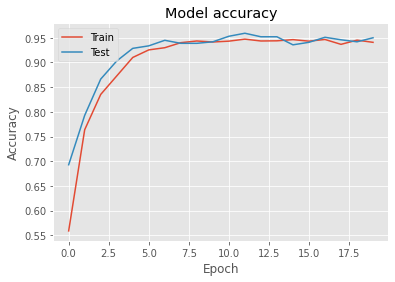

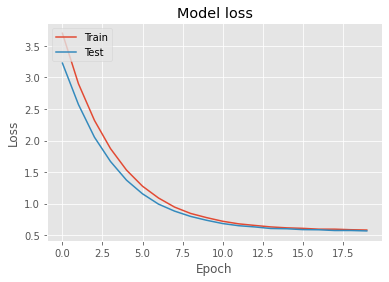

done with 3th training loop

0.3 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 27ms/step - loss: 3.5153 - accuracy: 0.5592 - val_loss: 3.0824 - val_accuracy: 0.7276
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 2.7894 - accuracy: 0.7750 - val_loss: 2.4508 - val_accuracy: 0.8327
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 2.2346 - accuracy: 0.8502 - val_loss: 1.9791 - val_accuracy: 0.8776
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 1.8024 - accuracy: 0.8921 - val_loss: 1.6114 - val_accuracy: 0.9143
Epoch 5/20
23/23 [==============================] - 1s 23ms/step - loss: 1.4777 - accuracy: 0.9135 - val_loss: 1.3406 - val_accuracy: 0.9071
Epoch 6/20
23/23 [==============================] - 1s 24ms/step - loss: 1.2460 - accuracy: 0.9187 - val_loss: 1.1362 - val_accuracy: 0.9245
Epoch 7/20
23/23 [==============================] - 0s 21ms/step - loss: 1.0712 - accuracy: 0.9251 - val_loss: 

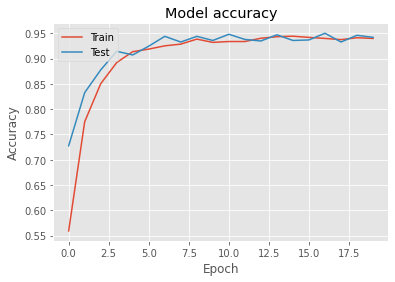

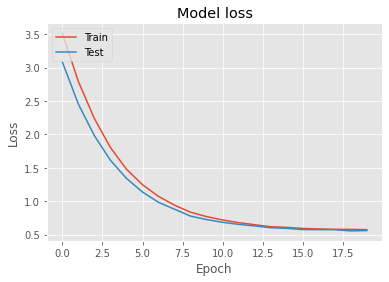

done with 4th training loop

0.35 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 25ms/step - loss: 3.2858 - accuracy: 0.5630 - val_loss: 2.8849 - val_accuracy: 0.7061
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 2.5890 - accuracy: 0.7740 - val_loss: 2.3027 - val_accuracy: 0.8112
Epoch 3/20
23/23 [==============================] - 1s 23ms/step - loss: 2.0933 - accuracy: 0.8468 - val_loss: 1.8709 - val_accuracy: 0.8582
Epoch 4/20
23/23 [==============================] - 1s 22ms/step - loss: 1.7137 - accuracy: 0.8836 - val_loss: 1.5242 - val_accuracy: 0.9061
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 1.4153 - accuracy: 0.9061 - val_loss: 1.2748 - val_accuracy: 0.9255
Epoch 6/20
23/23 [==============================] - 1s 22ms/step - loss: 1.1948 - accuracy: 0.9190 - val_loss: 1.0854 - val_accuracy: 0.9224
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - loss: 1.0303 - accuracy: 0.9221 - val_loss:

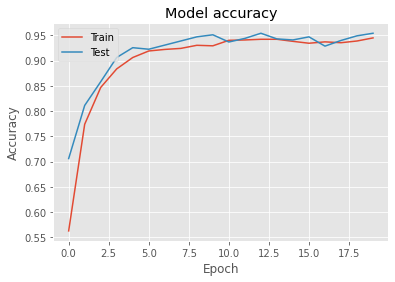

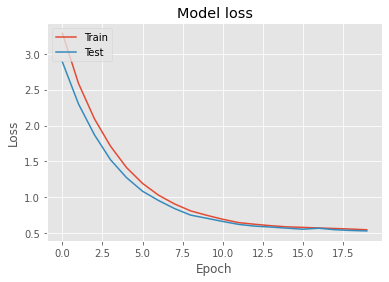

done with 5th training loop

0.4 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 27ms/step - loss: 3.1381 - accuracy: 0.5936 - val_loss: 2.7494 - val_accuracy: 0.7133
Epoch 2/20
23/23 [==============================] - 0s 21ms/step - loss: 2.5194 - accuracy: 0.7560 - val_loss: 2.2151 - val_accuracy: 0.8133
Epoch 3/20
23/23 [==============================] - 1s 24ms/step - loss: 2.0311 - accuracy: 0.8346 - val_loss: 1.8328 - val_accuracy: 0.8520
Epoch 4/20
23/23 [==============================] - 1s 24ms/step - loss: 1.6801 - accuracy: 0.8639 - val_loss: 1.5217 - val_accuracy: 0.8704
Epoch 5/20
23/23 [==============================] - 0s 20ms/step - loss: 1.4002 - accuracy: 0.8986 - val_loss: 1.2631 - val_accuracy: 0.9031
Epoch 6/20
23/23 [==============================] - 0s 21ms/step - loss: 1.1843 - accuracy: 0.9081 - val_loss: 1.0895 - val_accuracy: 0.9071
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - loss: 1.0190 - accuracy: 0.9187 - val_loss: 

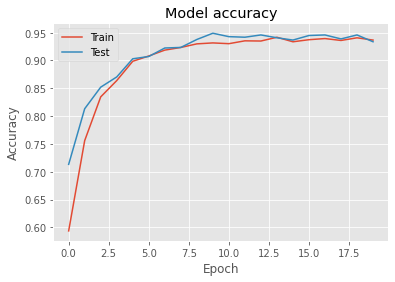

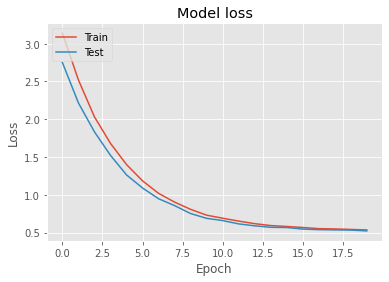

done with 6th training loop

0.45 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 22ms/step - loss: 3.0156 - accuracy: 0.5191 - val_loss: 2.6576 - val_accuracy: 0.6592
Epoch 2/20
23/23 [==============================] - 1s 24ms/step - loss: 2.4249 - accuracy: 0.7277 - val_loss: 2.1704 - val_accuracy: 0.7765
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 1.9709 - accuracy: 0.8295 - val_loss: 1.7748 - val_accuracy: 0.8388
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 1.6296 - accuracy: 0.8591 - val_loss: 1.4756 - val_accuracy: 0.8500
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 1.3681 - accuracy: 0.8850 - val_loss: 1.2446 - val_accuracy: 0.8888
Epoch 6/20
23/23 [==============================] - 0s 21ms/step - loss: 1.1626 - accuracy: 0.8972 - val_loss: 1.0687 - val_accuracy: 0.8969
Epoch 7/20
23/23 [==============================] - 0s 21ms/step - loss: 1.0098 - accuracy: 0.9078 - val_loss:

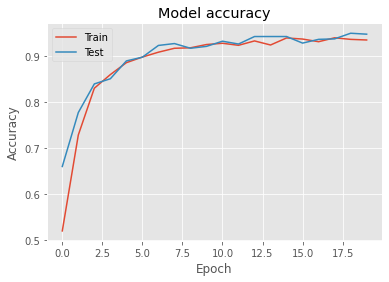

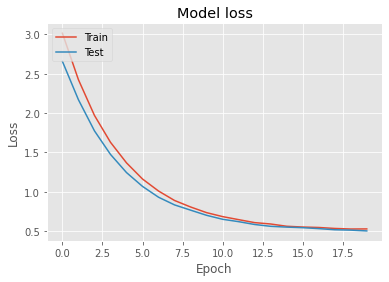

done with 7th training loop

0.5 dropout_p
Epoch 1/20
23/23 [==============================] - 1s 23ms/step - loss: 2.9225 - accuracy: 0.4537 - val_loss: 2.5874 - val_accuracy: 0.5969
Epoch 2/20
23/23 [==============================] - 0s 20ms/step - loss: 2.3586 - accuracy: 0.6784 - val_loss: 2.1256 - val_accuracy: 0.7367
Epoch 3/20
23/23 [==============================] - 1s 25ms/step - loss: 1.9596 - accuracy: 0.7706 - val_loss: 1.7670 - val_accuracy: 0.7959
Epoch 4/20
23/23 [==============================] - 0s 21ms/step - loss: 1.6345 - accuracy: 0.8182 - val_loss: 1.4973 - val_accuracy: 0.8469
Epoch 5/20
23/23 [==============================] - 1s 24ms/step - loss: 1.3835 - accuracy: 0.8533 - val_loss: 1.2490 - val_accuracy: 0.8806
Epoch 6/20
23/23 [==============================] - 0s 21ms/step - loss: 1.1792 - accuracy: 0.8877 - val_loss: 1.0848 - val_accuracy: 0.9010
Epoch 7/20
23/23 [==============================] - 1s 24ms/step - loss: 1.0358 - accuracy: 0.8904 - val_loss: 

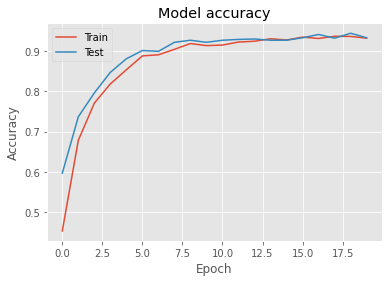

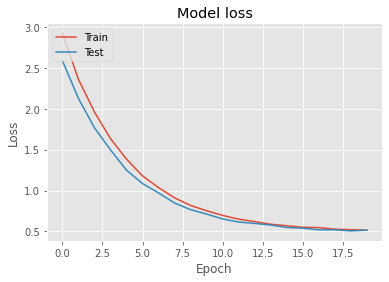

done with 8th training loop



In [ ]:
# tune for dropout probability
dropout_ps = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
num_classes = 3
epochs = 20
input_shape = (11)

for i, (dropout_p) in enumerate(dropout_ps):
  print(f"{dropout_p} dropout_p")
  model_orig = get_model(act="relu", dropout_prob=dropout_p, 
                          n_hidden=[64,64],
                          optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
  
  history_model_orig = model_orig.fit(X_wine_train, y_wine_train_type, 
                       validation_data=(X_wine_val, y_wine_val_type), 
                       batch_size=128, epochs=epochs, verbose=1)
  
  loss_accuracy_plot(history_model_orig)
  
  save_model(model=model_orig, batch_size=128, 
             n_epochs=epochs, descr="hyptunedropout_winemodel_learningrate" + str(0.001*1000), 
             n_hidden=[64,64], dropout=dropout_p)
  print(f"done with {i}th training loop\n")